In [98]:

import numpy as np
import pandas as pd
import lux
lux.logger = True

import matplotlib.pyplot as plt #Plotting
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)
plt.style.use("ggplot") #Define the style of the plot

import warnings #What to do with warnings
warnings.filterwarnings("ignore") #Ignore the warnings

import scipy.stats as sts
import pylab

from pmdarima import auto_arima

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose #Describes the time data
from statsmodels.tsa.stattools import adfuller #Check if data is stationary
from statsmodels.tsa.stattools import coint #Check if for cointegration
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf #Compute lag for ARIMA
from statsmodels.tsa.arima_model import ARIMA #Predictions and Forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX # sarimax

## Accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('Nifty50(2010-20).csv') ## 2010 to 2020
df.head()

,Date,Nifty50,reliance,infosys,hdfc,hdfcbank
0,2010-01-04,5232.20,1075.50,2612.60,2674.35,1705.70
1,2010-01-05,5277.90,1070.70,2621.35,2683.45,1707.20
2,2010-01-06,5281.80,1088.00,2583.10,2696.35,1708.35
3,2010-01-07,5263.10,1106.05,2525.05,2646.15,1712.80
4,2010-01-08,5244.75,1103.15,2464.20,2600.05,1715.05


In [3]:
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [4]:
df.tail()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [5]:
df.dtypes

Date         object
Nifty50     float64
reliance    float64
infosys     float64
hdfc        float64
hdfcbank    float64
dtype: object


In [6]:
df.shape

(2730, 6)

In [7]:
df.isna().sum()

Date        0
Nifty50     0
reliance    0
infosys     0
hdfc        0
hdfcbank    0
dtype: int64


In [8]:
df.describe()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [9]:
df.Date = pd.to_datetime(df.Date) ## to make is dd/mm/yy format

In [10]:
df.head()

,Date,Nifty50,reliance,infosys,hdfc,hdfcbank
0,2010-01-04,5232.20,1075.50,2612.60,2674.35,1705.70
1,2010-01-05,5277.90,1070.70,2621.35,2683.45,1707.20
2,2010-01-06,5281.80,1088.00,2583.10,2696.35,1708.35
3,2010-01-07,5263.10,1106.05,2525.05,2646.15,1712.80
4,2010-01-08,5244.75,1103.15,2464.20,2600.05,1715.05


In [11]:
df.dtypes

Date        datetime64[ns]
Nifty50            float64
reliance           float64
infosys            float64
hdfc               float64
hdfcbank           float64
dtype: object


In [12]:
df.set_index('Date' , inplace= True)


In [13]:
df.tail()

,Nifty50,reliance,infosys,hdfc,hdfcbank
Date,,,,,
2020-12-24,13749.25,1994.15,1236.05,2455.15,1397.10
2020-12-28,13873.20,2003.30,1240.30,2476.45,1412.85
2020-12-29,13932.60,1990.05,1250.30,2518.95,1427.20
2020-12-30,13981.95,1995.50,1246.80,2518.05,1432.50
2020-12-31,13981.75,1985.30,1255.80,2558.65,1436.30


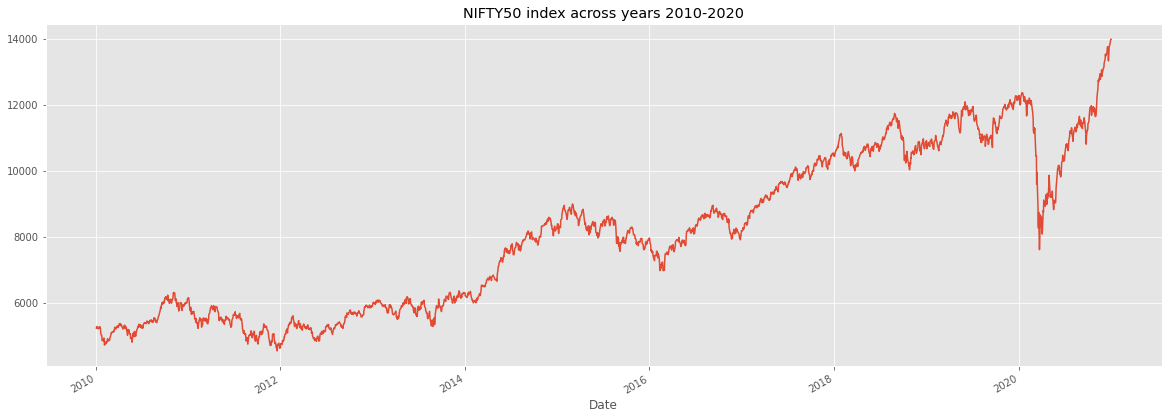

In [14]:
plt.figure(figsize=(20, 7))
df.Nifty50.plot()
plt.title("NIFTY50 index across years 2010-2020")
plt.show()

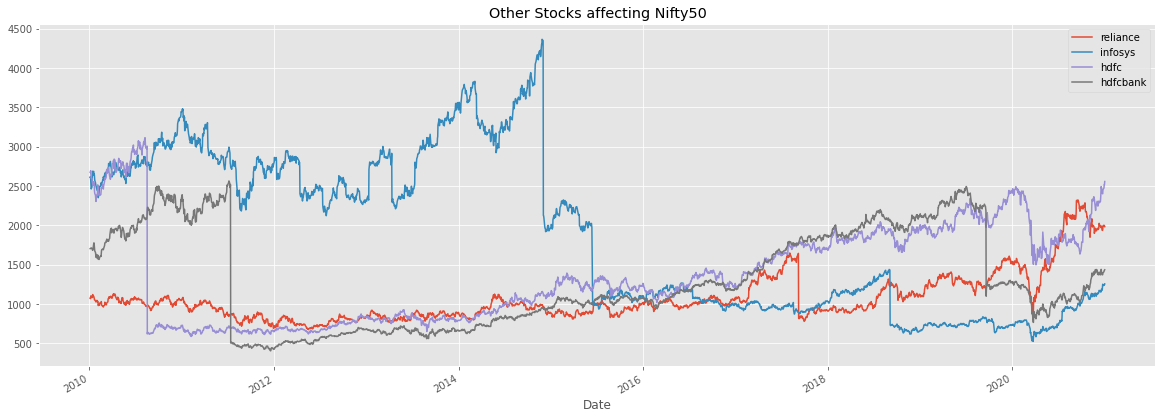

In [15]:
plt.figure(figsize=(20, 7))
df['reliance'].plot()
df['infosys'].plot()
df['hdfc'].plot()
df['hdfcbank'].plot()
plt.title("Other Stocks affecting Nifty50")
plt.legend(['reliance' ,'infosys','hdfc','hdfcbank' ])
plt.show()

## QQ-plot

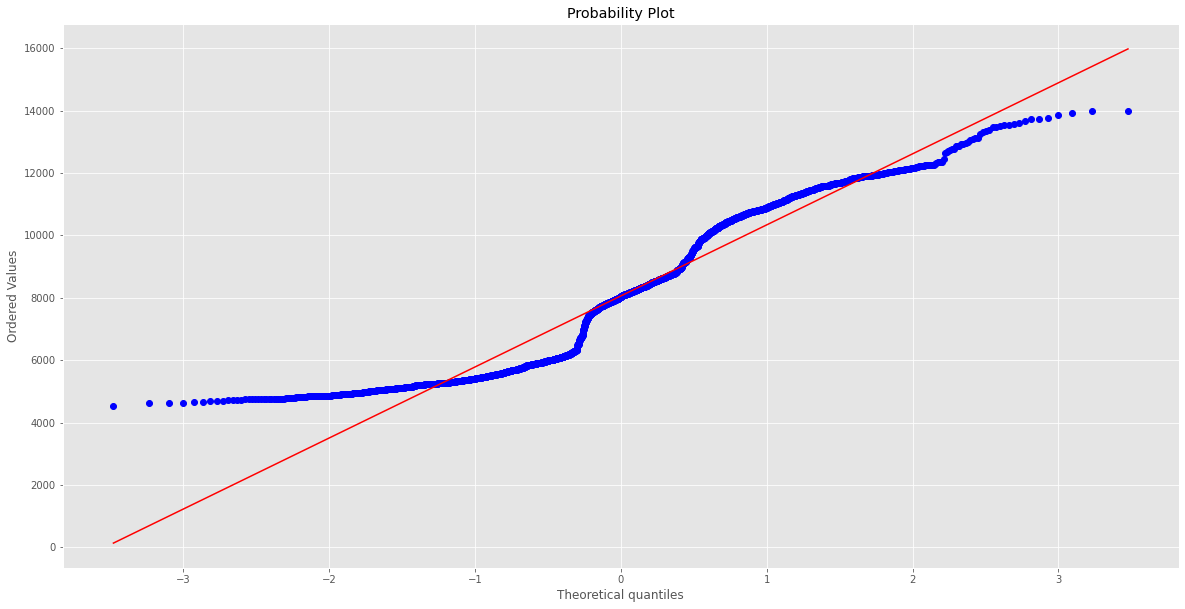

In [16]:
sts.probplot(df.Nifty50 , plot=pylab)
pylab.show()

## Stationarity

In [17]:
def adf_test(timeseries):
    ''' Dicky Fuller test
        h0 = Not stationary
        h1 = stationary
    '''
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if(dfoutput['p-value'] > 0.05):
        print("We fail to reject null hypothesis that Time Series is not Stationary\n")
    else:
        print("We reject null hypothesis that Time Series is not Stationary\n")



In [18]:
print(adf_test(df.Nifty50))

Results of Dickey-Fuller Test:


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()


We fail to reject null hypothesis that Time Series is not Stationary

None


#### We fail to reject null hypothesis as p-val > 0.05 and test statistic is > critical value

## Use returns instead of prices

In [19]:
df['nifty_returns'] = df.Nifty50.pct_change(1).mul(100)
df['reliance_returns'] = df.reliance.pct_change(1).mul(100)
df['infosys_returns'] = df.infosys.pct_change(1).mul(100)
df['hdfc_returns'] = df.hdfc.pct_change(1).mul(100)
df['hdfcbank_returns'] = df.hdfcbank.pct_change(1).mul(100)
df.dropna(inplace=True)
df.head()

,Nifty50,reliance,infosys,hdfc,hdfcbank,nifty_returns,reliance_returns,infosys_returns,hdfc_returns,hdfcbank_returns
Date,,,,,,,,,,
2010-01-05,5277.90,1070.70,2621.35,2683.45,1707.20,0.873438,-0.446304,0.334915,0.340270,0.087940
2010-01-06,5281.80,1088.00,2583.10,2696.35,1708.35,0.073893,1.615765,-1.459172,0.480724,0.067362
2010-01-07,5263.10,1106.05,2525.05,2646.15,1712.80,-0.354046,1.659007,-2.247300,-1.861776,0.260485
2010-01-08,5244.75,1103.15,2464.20,2600.05,1715.05,-0.348654,-0.262194,-2.409853,-1.742154,0.131364
2010-01-11,5249.40,1081.50,2489.65,2600.10,1708.15,0.088660,-1.962562,1.032790,0.001923,-0.402321


In [20]:
print(adf_test(df.nifty_returns))

Results of Dickey-Fuller Test:


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()


We reject null hypothesis that Time Series is not Stationary

None


#### We reject null hypothesis as p-val < 0.05 and test statistic is < critical value

## Squared Returns to check volatility

In [21]:
df['nifty_sq_returns'] = df.nifty_returns**2
df['reliance_sq_returns'] = df.reliance_returns**2
df['infosys_sq_returns'] = df.infosys_returns**2
df['hdfc_sq_returns'] = df.hdfc_returns**2
df['hdfcbank_sq_returns'] = df.hdfcbank_returns**2
df.head()

,Nifty50,reliance,infosys,hdfc,hdfcbank,nifty_returns,reliance_returns,infosys_returns,hdfc_returns,hdfcbank_returns,nifty_sq_returns,reliance_sq_returns,infosys_sq_returns,hdfc_sq_returns,hdfcbank_sq_returns
Date,,,,,,,,,,,,,,,
2010-01-05,5277.90,1070.70,2621.35,2683.45,1707.20,0.873438,-0.446304,0.334915,0.340270,0.087940,0.762893,0.199187,0.112168,0.115783,0.007734
2010-01-06,5281.80,1088.00,2583.10,2696.35,1708.35,0.073893,1.615765,-1.459172,0.480724,0.067362,0.005460,2.610698,2.129182,0.231096,0.004538
2010-01-07,5263.10,1106.05,2525.05,2646.15,1712.80,-0.354046,1.659007,-2.247300,-1.861776,0.260485,0.125349,2.752305,5.050356,3.466210,0.067853
2010-01-08,5244.75,1103.15,2464.20,2600.05,1715.05,-0.348654,-0.262194,-2.409853,-1.742154,0.131364,0.121559,0.068746,5.807393,3.035099,0.017256
2010-01-11,5249.40,1081.50,2489.65,2600.10,1708.15,0.088660,-1.962562,1.032790,0.001923,-0.402321,0.007861,3.851649,1.066654,0.000004,0.161862


In [22]:
df

,Nifty50,reliance,infosys,hdfc,hdfcbank,nifty_returns,reliance_returns,infosys_returns,hdfc_returns,hdfcbank_returns,nifty_sq_returns,reliance_sq_returns,infosys_sq_returns,hdfc_sq_returns,hdfcbank_sq_returns
Date,,,,,,,,,,,,,,,
2010-01-05,5277.90,1070.70,2621.35,2683.45,1707.20,0.873438,-0.446304,0.334915,0.340270,0.087940,0.762893,0.199187,0.112168,0.115783,0.007734
2010-01-06,5281.80,1088.00,2583.10,2696.35,1708.35,0.073893,1.615765,-1.459172,0.480724,0.067362,0.005460,2.610698,2.129182,0.231096,0.004538
2010-01-07,5263.10,1106.05,2525.05,2646.15,1712.80,-0.354046,1.659007,-2.247300,-1.861776,0.260485,0.125349,2.752305,5.050356,3.466210,0.067853
2010-01-08,5244.75,1103.15,2464.20,2600.05,1715.05,-0.348654,-0.262194,-2.409853,-1.742154,0.131364,0.121559,0.068746,5.807393,3.035099,0.017256
2010-01-11,5249.40,1081.50,2489.65,2600.10,1708.15,0.088660,-1.962562,1.032790,0.001923,-0.402321,0.007861,3.851649,1.066654,0.000004,0.161862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,13749.25,1994.15,1236.05,2455.15,1397.10,1.089250,2.587648,-1.356690,2.168078,1.559263,1.186466,6.695923,1.840607,4.700563,2.431301
2020-12-28,13873.20,2003.30,1240.30,2476.45,1412.85,0.901504,0.458842,0.343837,0.867564,1.127335,0.812709,0.210536,0.118224,0.752667,1.270885
2020-12-29,13932.60,1990.05,1250.30,2518.95,1427.20,0.428164,-0.661409,0.806257,1.716166,1.015678,0.183324,0.437461,0.650050,2.945227,1.031601


In [23]:
df[['Nifty50' , 'reliance' , 'infosys' ,'hdfc' , 'hdfcbank']].corr()

,Nifty50,reliance,infosys,hdfc,hdfcbank
Nifty50,1.000000,0.690545,-0.777023,0.620018,0.390892
reliance,0.690545,1.000000,-0.510155,0.561145,0.271654
infosys,-0.777023,-0.510155,1.000000,-0.552132,-0.305813
hdfc,0.620018,0.561145,-0.552132,1.000000,0.512937
hdfcbank,0.390892,0.271654,-0.305813,0.512937,1.000000


In [24]:
df[['nifty_returns' , 'reliance_returns' , 'infosys_returns' ,'hdfc_returns' , 'hdfcbank_returns']].corr()

,nifty_returns,reliance_returns,infosys_returns,hdfc_returns,hdfcbank_returns
nifty_returns,1.000000,0.590439,0.337734,0.528017,0.475357
reliance_returns,0.590439,1.000000,0.138907,0.256894,0.246762
infosys_returns,0.337734,0.138907,1.000000,0.115987,0.133062
hdfc_returns,0.528017,0.256894,0.115987,1.000000,0.286104
hdfcbank_returns,0.475357,0.246762,0.133062,0.286104,1.000000


In [25]:
df = sm.add_constant(df)
df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [26]:
print(adf_test(df.nifty_returns))

Results of Dickey-Fuller Test:


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()


We reject null hypothesis that Time Series is not Stationary

None


## ACF

<Figure size 1440x576 with 0 Axes>

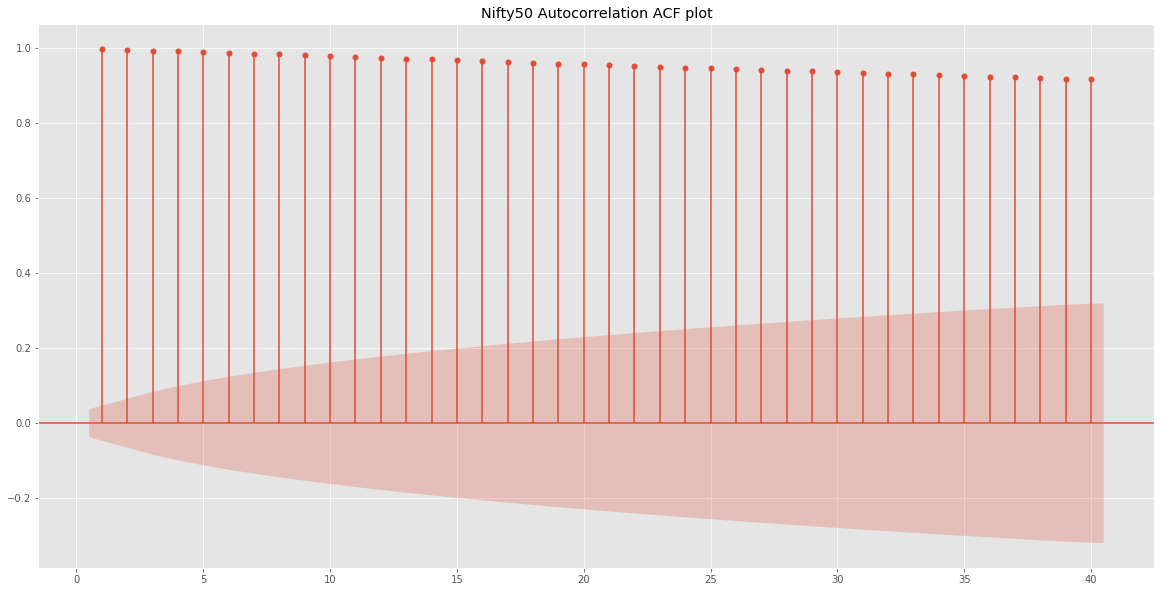

In [27]:
plt.figure(figsize=(20,8))
plot_acf(df['Nifty50'] , lags= 40 , alpha=0.05 ,zero=False)
plt.title("Nifty50 Autocorrelation ACF plot")
plt.show()

<Figure size 1440x576 with 0 Axes>

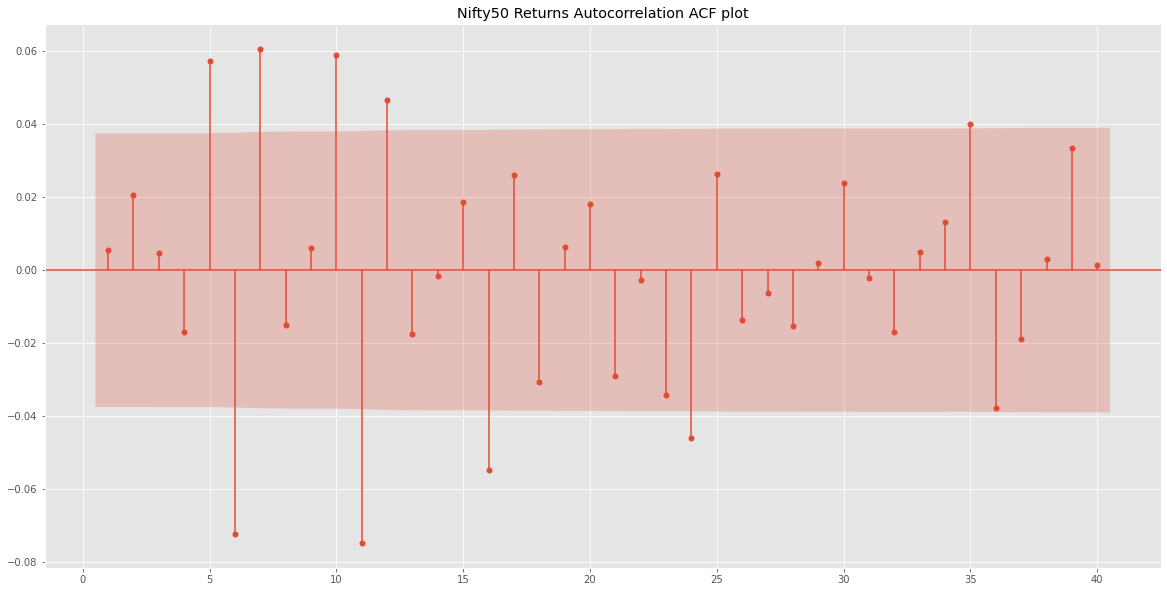

In [28]:
plt.figure(figsize=(20,8))
plot_acf(df['nifty_returns'] , lags= 40 , alpha=0.05 ,zero=False)
plt.title("Nifty50 Returns Autocorrelation ACF plot")
plt.show()

## PACF

<Figure size 1440x576 with 0 Axes>

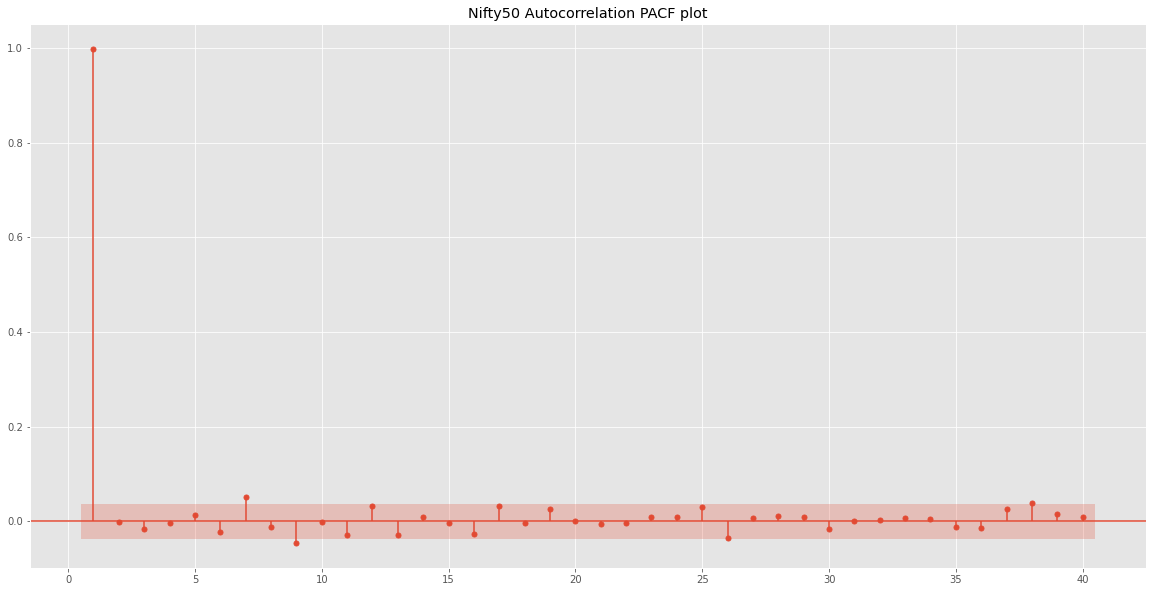

In [29]:
plt.figure(figsize=(20,8))
plot_pacf(df['Nifty50'] , lags= 40 , alpha=0.05 ,zero=False)
plt.title("Nifty50 Autocorrelation PACF plot")
plt.show()

<Figure size 1440x576 with 0 Axes>

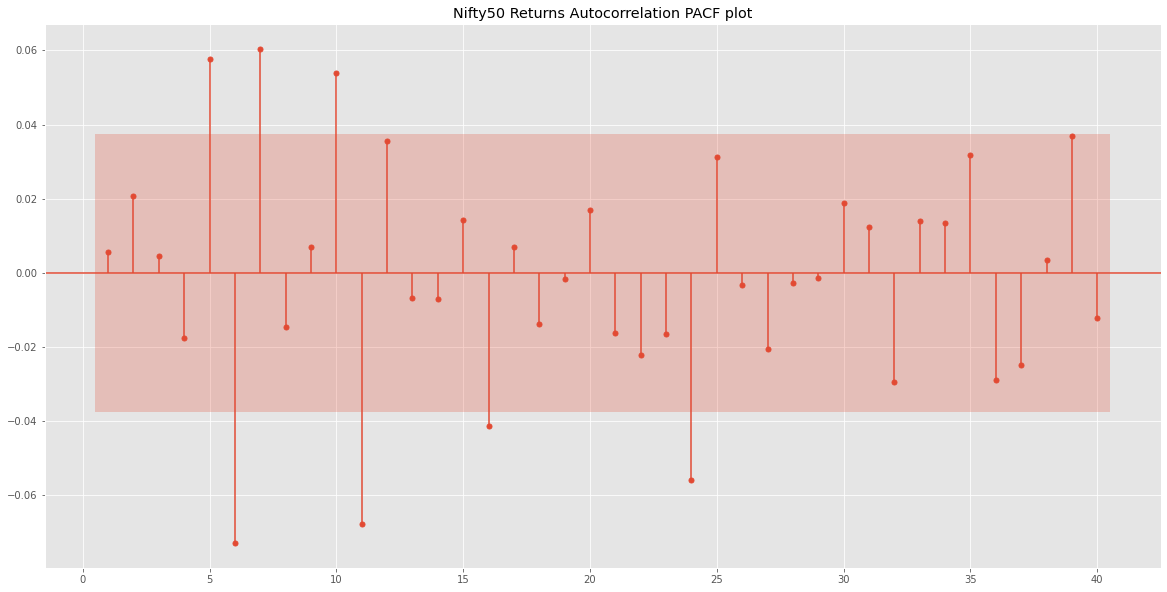

In [30]:
plt.figure(figsize=(20,8))
plot_pacf(df['nifty_returns'] , lags= 40 , alpha=0.05 ,zero=False)
plt.title("Nifty50 Returns Autocorrelation PACF plot")
plt.show()

## Cointegration

In [31]:
# The null hypothesis is no cointegration. Variables in y0 and y1 are assumed to be integrated of order 1, I(1).

#This uses the augmented Engle-Granger two-step cointegration test. 
#Constant or trend is included in 1st stage regression, i.e. in cointegrating equation.

# The Null hypothesis is that there is no cointegration, 
# the alternative hypothesis is that there is cointegrating relationship. 
# If the pvalue is small, below a critical size, 
# then we can reject the hypothesis that there is no cointegrating relationship.

# P-values and critical values are obtained through regression surface approximation from MacKinnon 1994 and 2010.

# If the two series are almost perfectly collinear, then computing the test is numerically unstable. 
# However, the two series will be cointegrated under the maintained assumption that they are integrated. 
# In this case the t-statistic will be set to -inf and the pvalue to zero.



score, pvalue, _ = coint(df['Nifty50'] , df['reliance'])
print ('coint score =',score,'\nthe pvalue =', pvalue, 
       '\n1% 5% & 10% = ',_)


coint score = -2.230460558281334 
the pvalue = 0.40871574364434804 
1% 5% & 10% =  [-3.90045913 -3.33837069 -3.04600506]


### co integration should be done on price difference, not return difference.

## Visual EDA

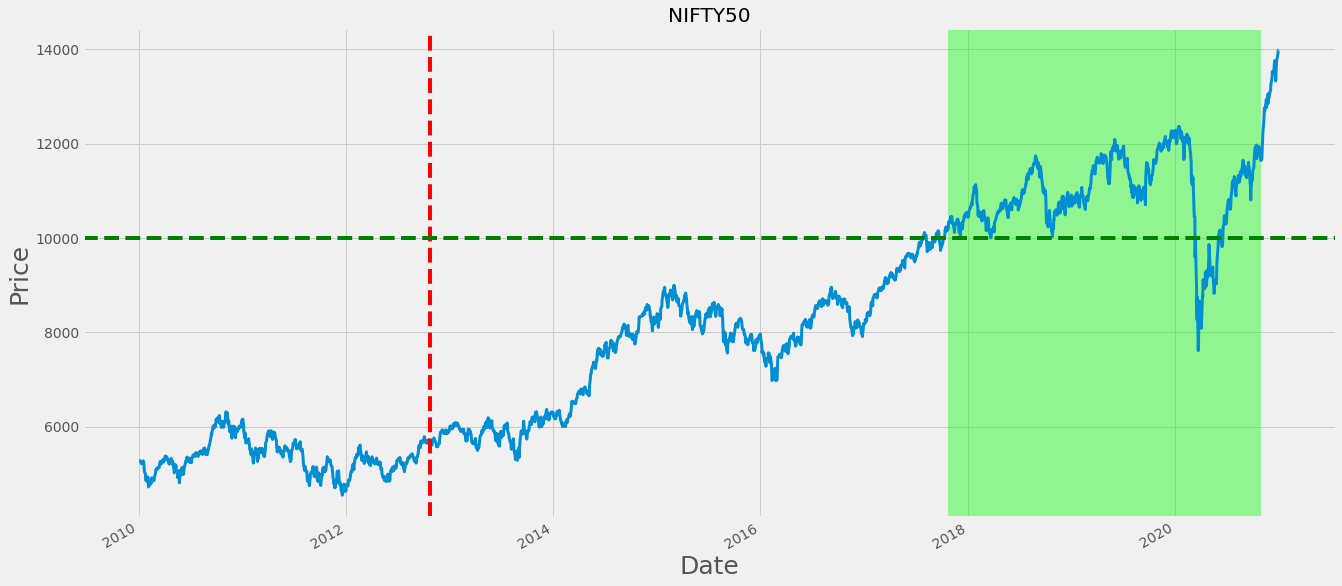

In [32]:
plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')
ax = df['Nifty50'].plot(linewidth = 3)
ax.set_xlabel("Date" , fontsize = 25)
ax.set_ylabel("Price" , fontsize = 25)
ax.axvline(x = '2012-10-25' , color = 'red' , linestyle='--')
ax.axhline(y = 10000 , color = 'green' , linestyle='--')
ax.axvspan('2017-10-25' , '2020-10-25' , color = 'lime' , alpha = 0.4 )
# ax.axhspan(10000 , 12000 , color = 'yellow' )
ax.set_title("NIFTY50")
plt.show()

## Aggreagate DAta

In [33]:
nifty = df[['Nifty50']]
nifty

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

#### Moving Averge model
Window size 30 => mean of last 30 rows is todays price

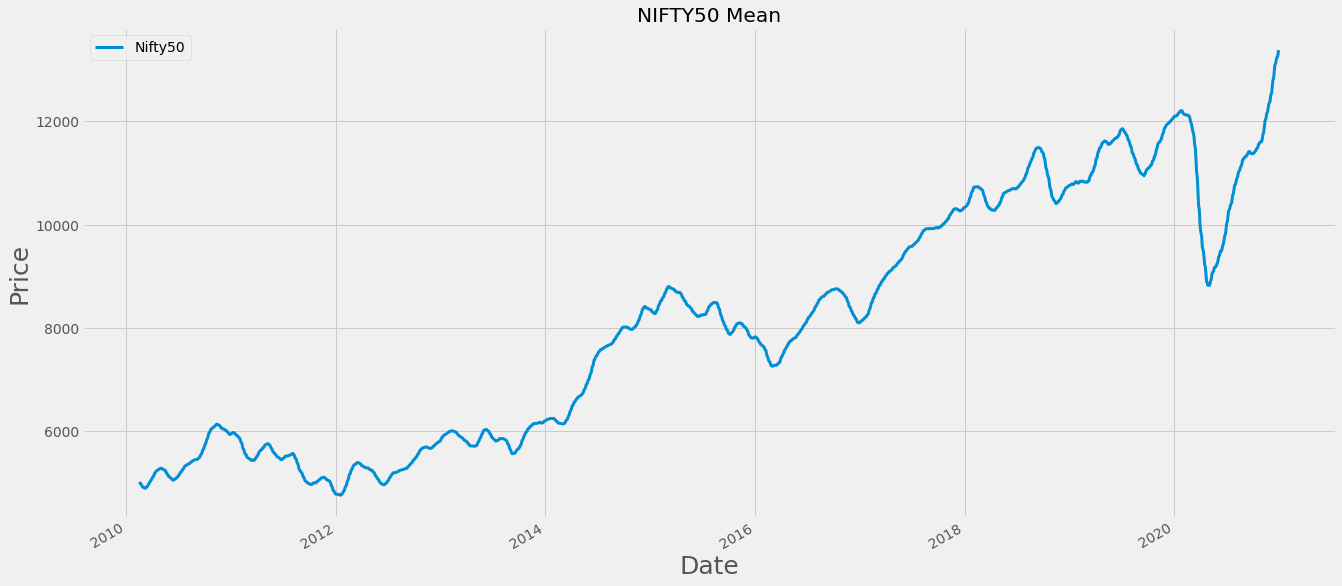

In [34]:
nifty_mean = nifty.rolling(window=30).mean()
ax = nifty_mean.plot(linewidth = 3)
ax.set_xlabel("Date" , fontsize = 25)
ax.set_ylabel("Price" , fontsize = 25)
ax.set_title("NIFTY50 Mean")
plt.show()

In [35]:
nifty_mean

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

## Monthly Prices

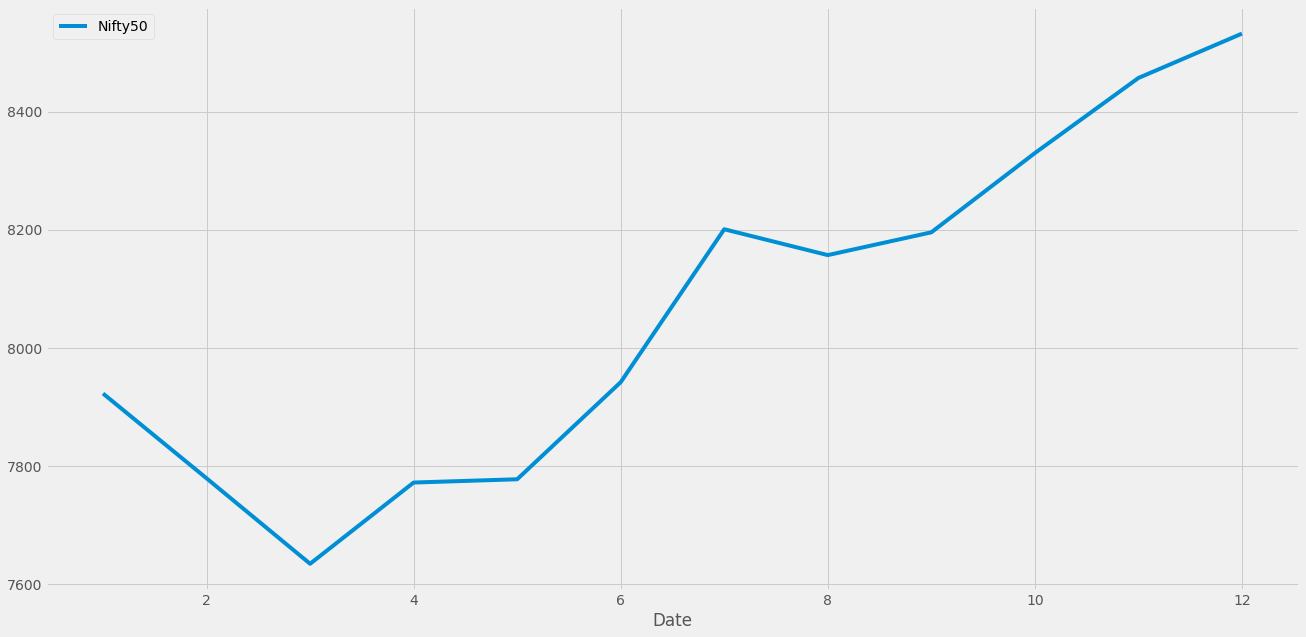

In [36]:
index_month = nifty.index.month
nifty_month = nifty.groupby(index_month).mean()
nifty_month.plot()
plt.show()

In [37]:
nifty_month

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

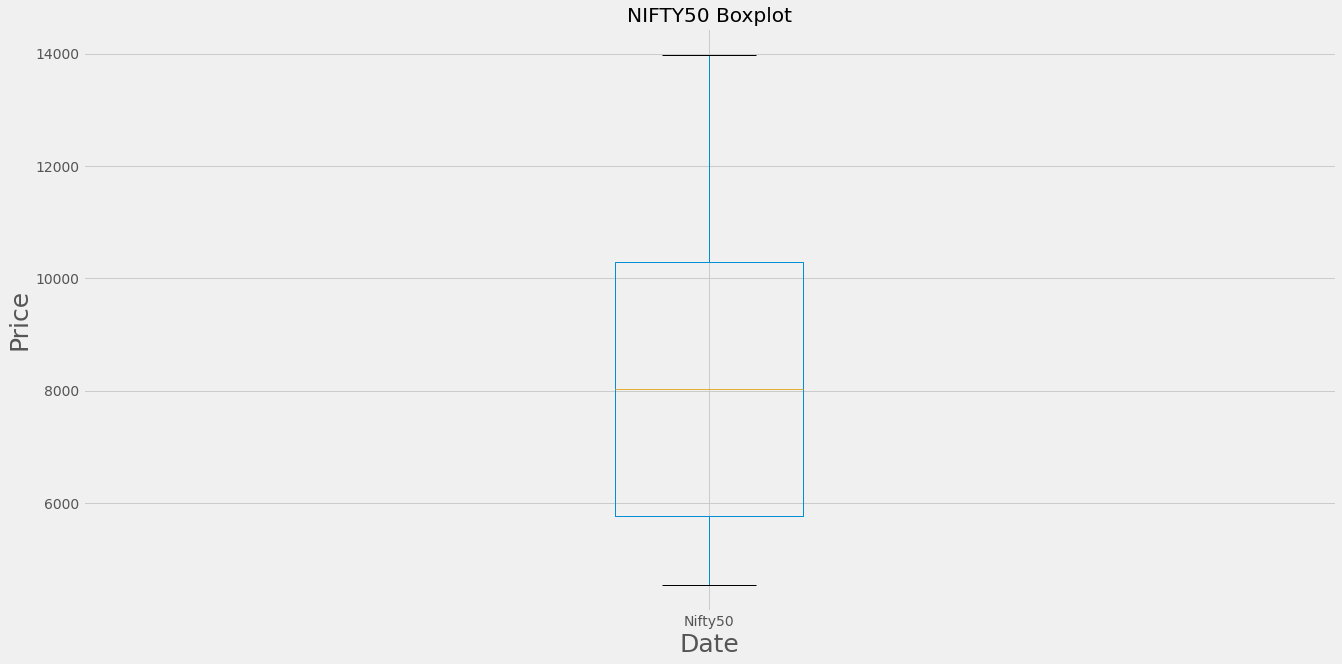

In [38]:
ax = nifty.boxplot()
ax.set_xlabel("Date" , fontsize = 25)
ax.set_ylabel("Price" , fontsize = 25)
ax.set_title("NIFTY50 Boxplot")
plt.show()

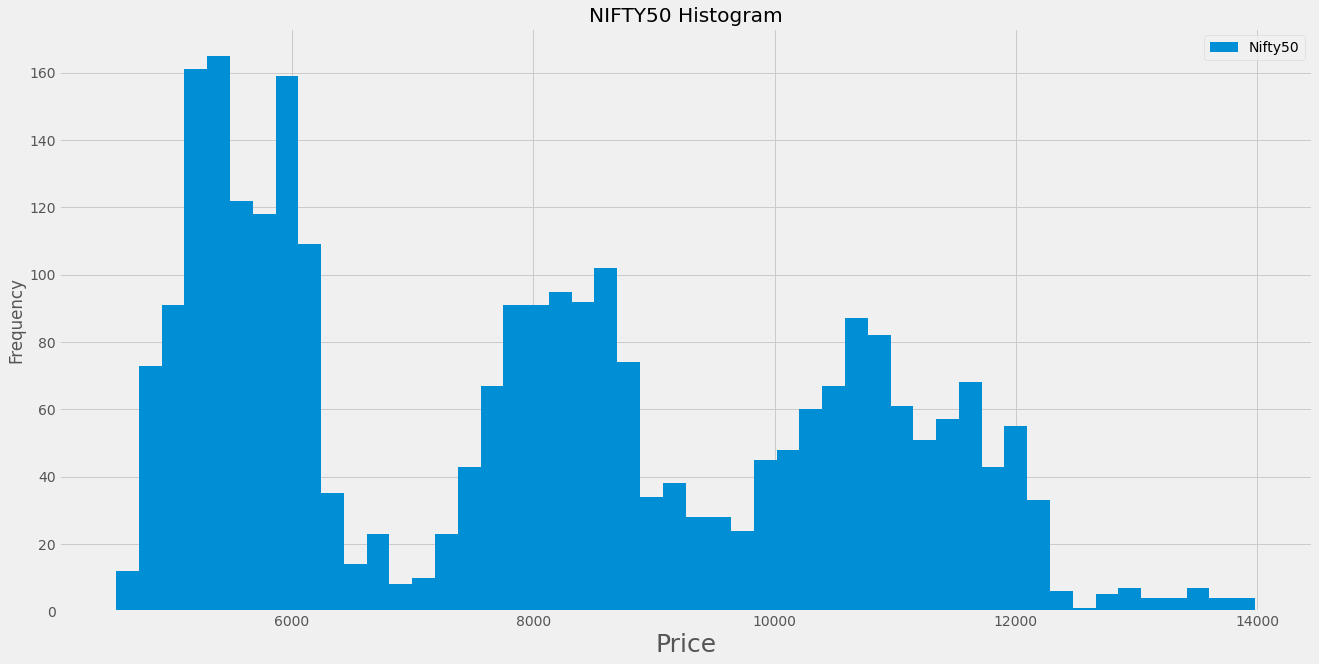

In [39]:
ax = nifty.plot(kind = "hist" , bins = 50)
# ax.set_xlabel("Date" , fontsize = 25)
ax.set_xlabel("Price" , fontsize = 25)
ax.set_title("NIFTY50 Histogram")
plt.show()

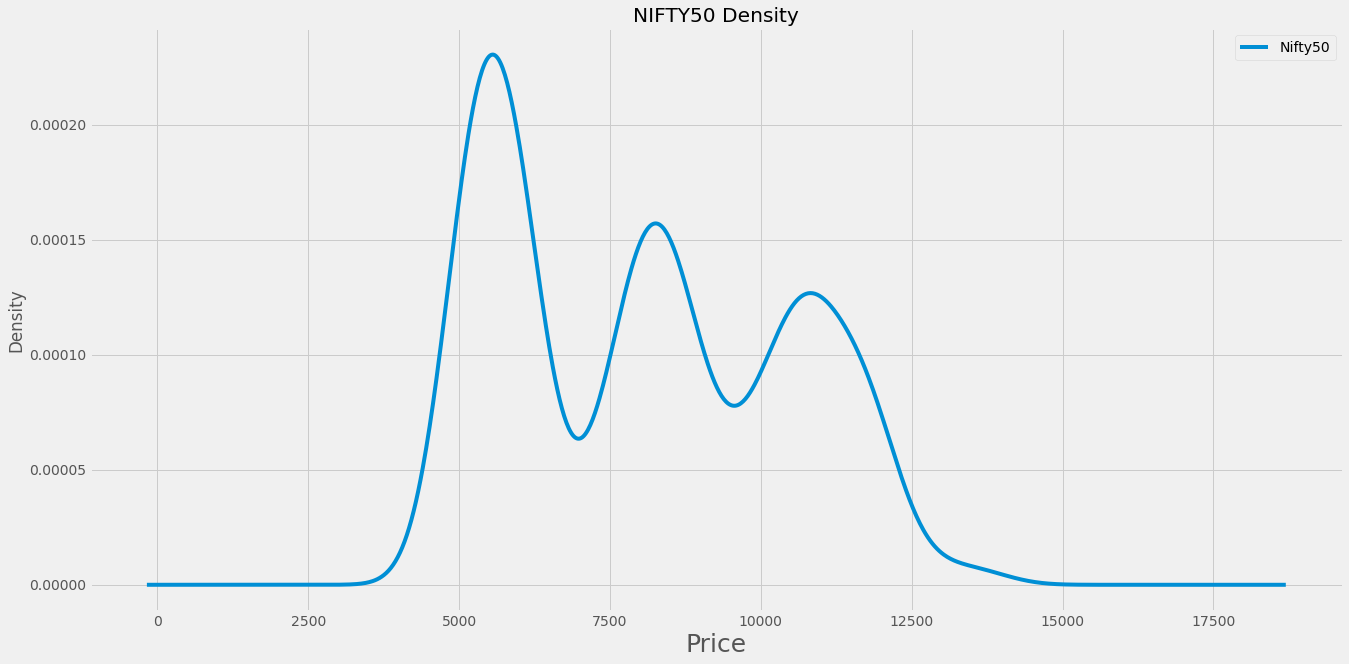

In [40]:
ax = nifty.plot(kind = "density" )
# ax.set_xlabel("Date" , fontsize = 25)
ax.set_xlabel("Price" , fontsize = 25)
ax.set_title("NIFTY50 Density")
plt.show()

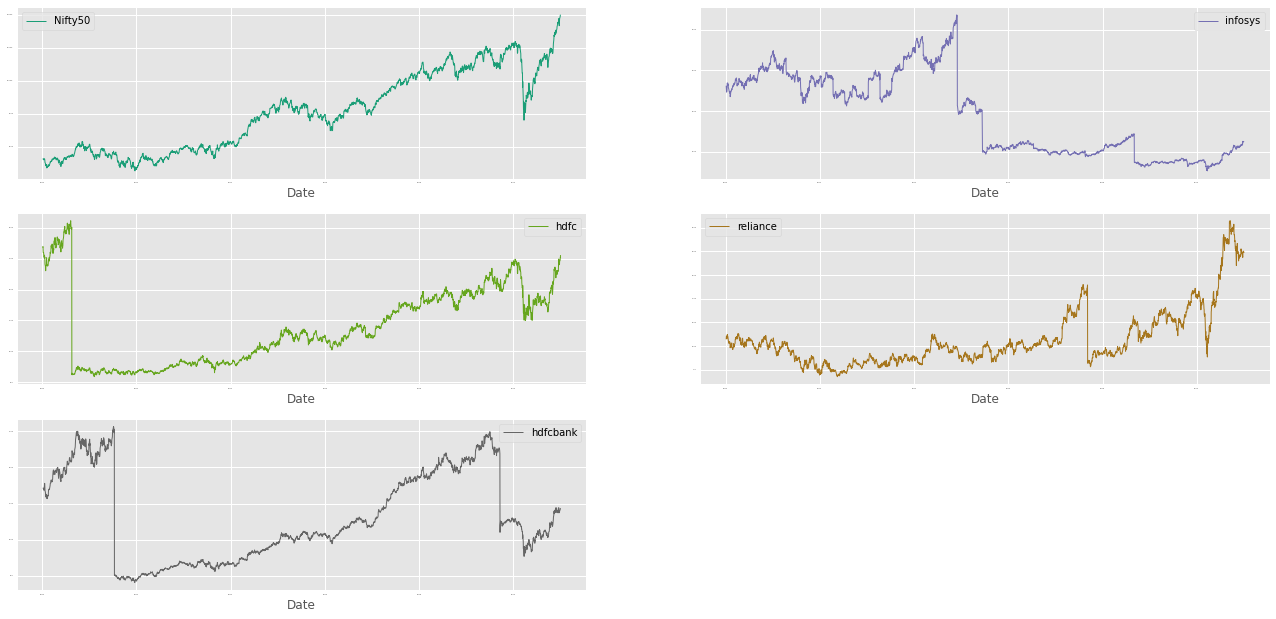

In [41]:
plt.style.use('ggplot')
df[['Nifty50' ,'infosys','hdfc','reliance','hdfcbank' ]].plot(subplots=True, 
          layout=(3,2), 
          sharex=False, 
          sharey=False, 
          colormap='Dark2', 
          fontsize=2, 
          legend=True, 
          linewidth=1)

plt.show()

In [42]:
corrmat = df[['Nifty50' , 'reliance' , 'infosys' ,'hdfc' , 'hdfcbank']].corr()

In [43]:
corrmat_ret = df[['nifty_returns' , 'reliance_returns' , 'infosys_returns' ,'hdfc_returns' , 'hdfcbank_returns']].corr()

In [44]:
import seaborn as sns

In [45]:
corrmat

,Nifty50,reliance,infosys,hdfc,hdfcbank
Nifty50,1.000000,0.690545,-0.777023,0.620018,0.390892
reliance,0.690545,1.000000,-0.510155,0.561145,0.271654
infosys,-0.777023,-0.510155,1.000000,-0.552132,-0.305813
hdfc,0.620018,0.561145,-0.552132,1.000000,0.512937
hdfcbank,0.390892,0.271654,-0.305813,0.512937,1.000000


<AxesSubplot:>

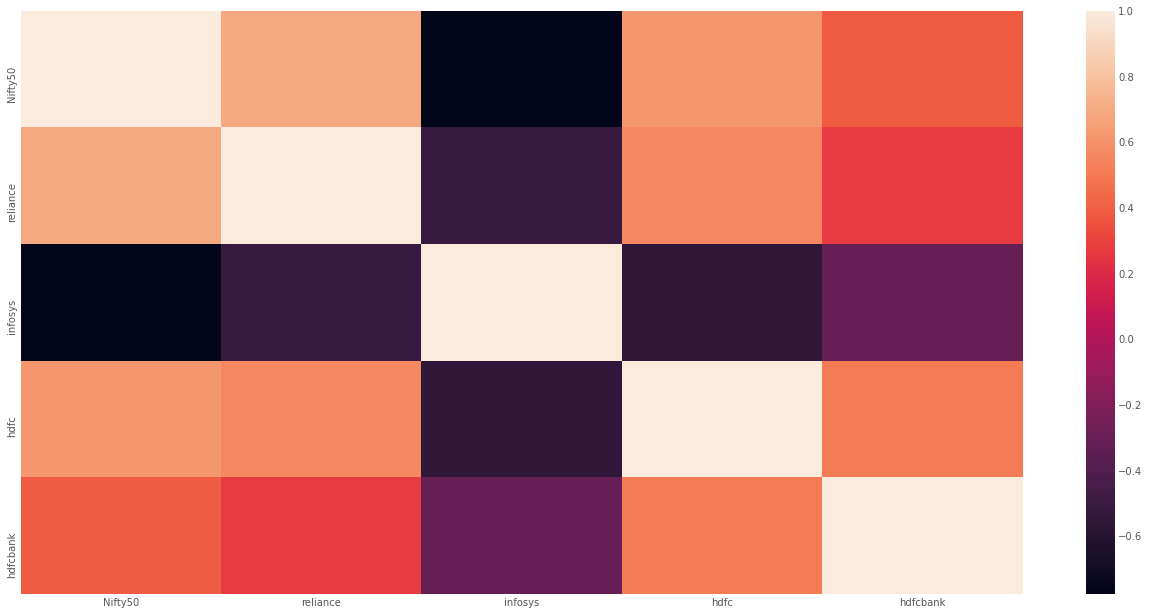

In [46]:
sns.heatmap(corrmat)

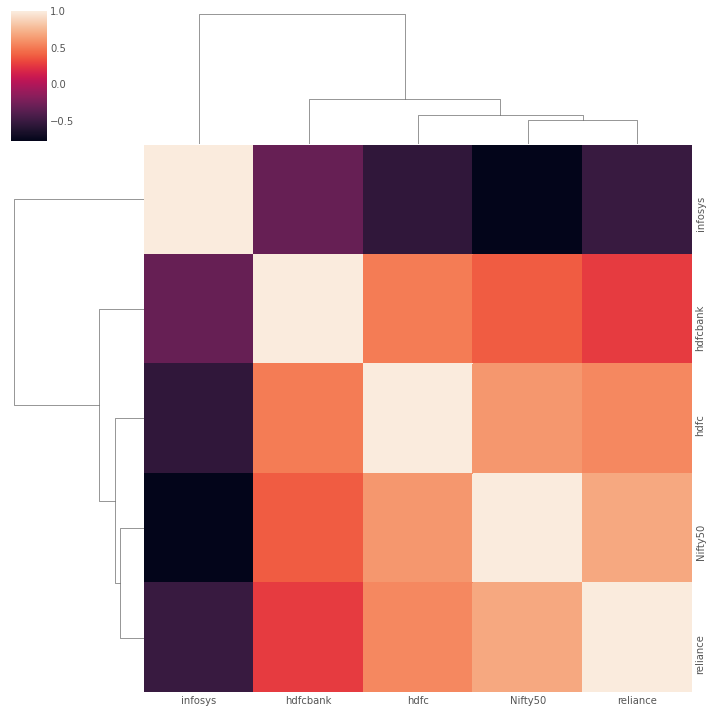

In [47]:
sns.clustermap(corrmat)

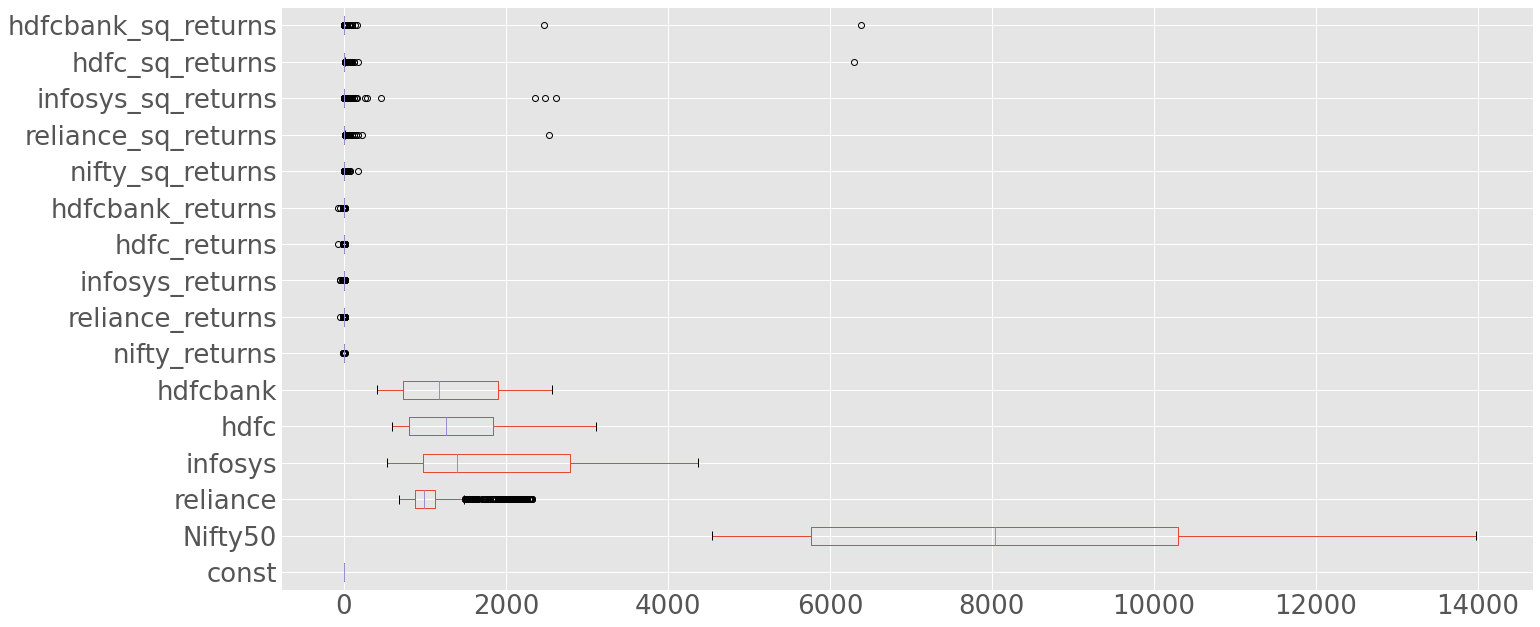

In [48]:
# Generate a boxplot
df.boxplot(fontsize=26, vert=False)
plt.show()

## Train Test Split

In [49]:
size = int(len(df.Nifty50)*0.8) ## 80%
size

2183

In [50]:
Train = df.iloc[:size]
Test = df.iloc[size:]

In [51]:
Train.tail().index

DatetimeIndex(['2018-10-11', '2018-10-12', '2018-10-15', '2018-10-16',
               '2018-10-17'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [52]:
Test.head().index

DatetimeIndex(['2018-10-19', '2018-10-22', '2018-10-23', '2018-10-24',
               '2018-10-25'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [53]:
print(Train.shape , Test.shape)

(2183, 16) (546, 16)


## WIthout Exogenous

In [54]:
model_auto_pred = auto_arima(Train['Nifty50'],
                 max_p=5 , max_q= 5 , max_P= 5 , max_Q= 5 ,trace=True,
                            stepwise=True, error_action='ignore', seasonal=True, m=12)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=24543.730, Time=2.10 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=24544.542, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=24536.304, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=24536.009, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=24545.276, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=24534.682, Time=0.22 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=24536.034, Time=0.37 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=24537.943, Time=1.88 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=24536.550, Time=0.54 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=24536.535, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=24534.943, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=24538.529, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=24535.048, Time=0.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 6.905 sec

In [55]:
model_auto_pred.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2183
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -12264.341
Date:                Sun, 25 Apr 2021   AIC                          24534.682
Time:                        19:44:04   BIC                          24551.746
Sample:                             0   HQIC                         24540.920
                               - 2183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3128      1.569      1.474      0.140      -0.762       5.387
ma.L1          0.0745      0.019      3.937      0.000       0.037       0.112
sigma2      4459.2130     96.025     46.438      0.000    4271.007    4647.419
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               426.96
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

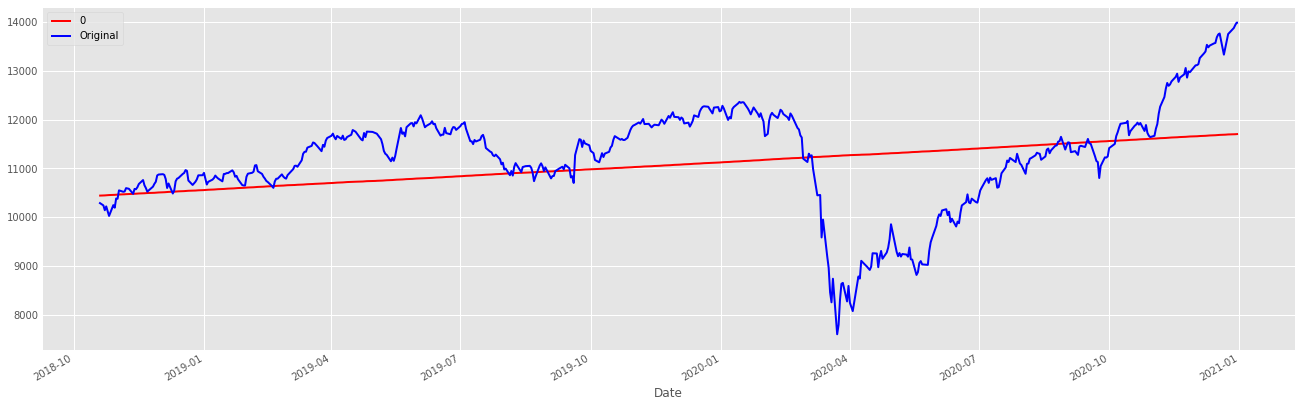

In [56]:

df_result_price = pd.DataFrame(model_auto_pred.predict(n_periods = len(Test)) ,index =Test.index)
df_result_price.plot(figsize=(20,7) ,color = "red" , label = "Predictions" , lw = 2)
Test['Nifty50'].plot(figsize=(20,7),color = "blue" , label = "Original" , lw = 2)
plt.legend()
plt.show()

In [57]:
print( "RMSE :" ,np.sqrt(mean_squared_error(Test['Nifty50'],df_result_price)))
print("MAE :" , mean_absolute_error(Test['Nifty50'],df_result_price))

RMSE : 1041.1076528536144
MAE : 786.5286359161511


                             ARIMA Model Results                              
Dep. Variable:              D.Nifty50   No. Observations:                 2182
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -12264.341
Method:                       css-mle   S.D. of innovations             66.803
Date:                Sun, 25 Apr 2021   AIC                          24534.682
Time:                        19:44:04   BIC                          24551.746
Sample:                             1   HQIC                         24540.920
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.3676      1.537      1.541      0.123      -0.644       5.379
ma.L1.D.Nifty50     0.0745      0.022      3.459      0.001       0.032       0.117
                                

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


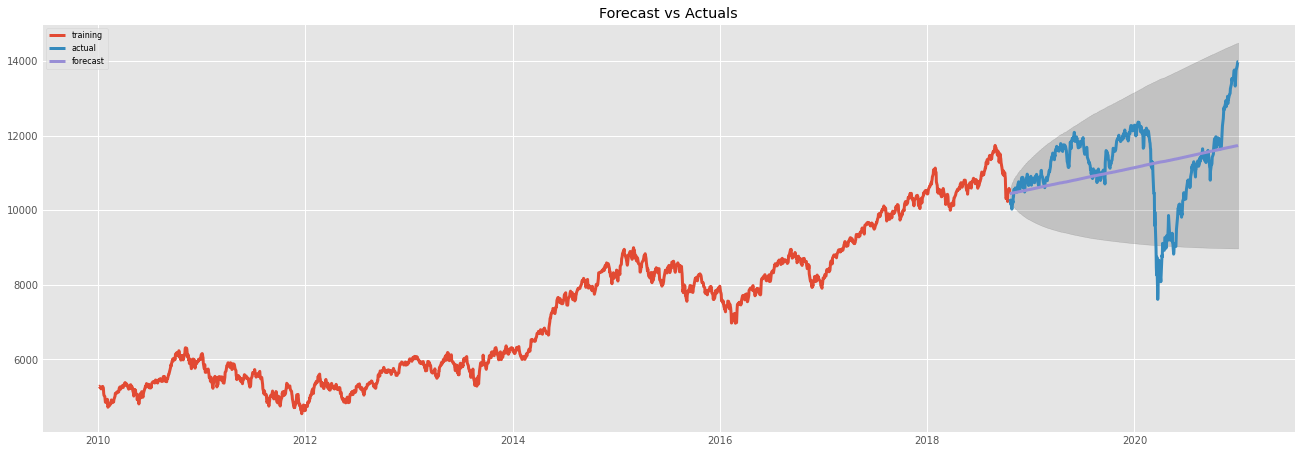

In [58]:
# Build Model
 
model = ARIMA(Train['Nifty50'], order=(0, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(len(Test), alpha=0.1)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=Test.index)
lower_series = pd.Series(conf[:, 0], index=Test.index)
upper_series = pd.Series(conf[:, 1], index=Test.index)

# Plot
plt.figure(figsize=(20,7))
plt.plot(Train['Nifty50'], label='training' , lw = 3)
plt.plot(Test['Nifty50'], label='actual' ,lw = 3)
plt.plot(fc_series, label='forecast' , lw = 3)
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [59]:
print( "RMSE :" ,np.sqrt(mean_squared_error(Test['Nifty50'],fc)))
print("MAE :" , mean_absolute_error(Test['Nifty50'],fc))

RMSE : 1040.3837871408793
MAE : 783.6910409895792


## Future Dates

                             ARIMA Model Results                              
Dep. Variable:              D.Nifty50   No. Observations:                 2728
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -16122.028
Method:                       css-mle   S.D. of innovations             89.201
Date:                Sun, 25 Apr 2021   AIC                          32250.056
Time:                        19:46:52   BIC                          32267.790
Sample:                             1   HQIC                         32256.466
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.1906      1.703      1.873      0.061      -0.148       6.529
ma.L1.D.Nifty50    -0.0026      0.018     -0.143      0.886      -0.039       0.033
                                

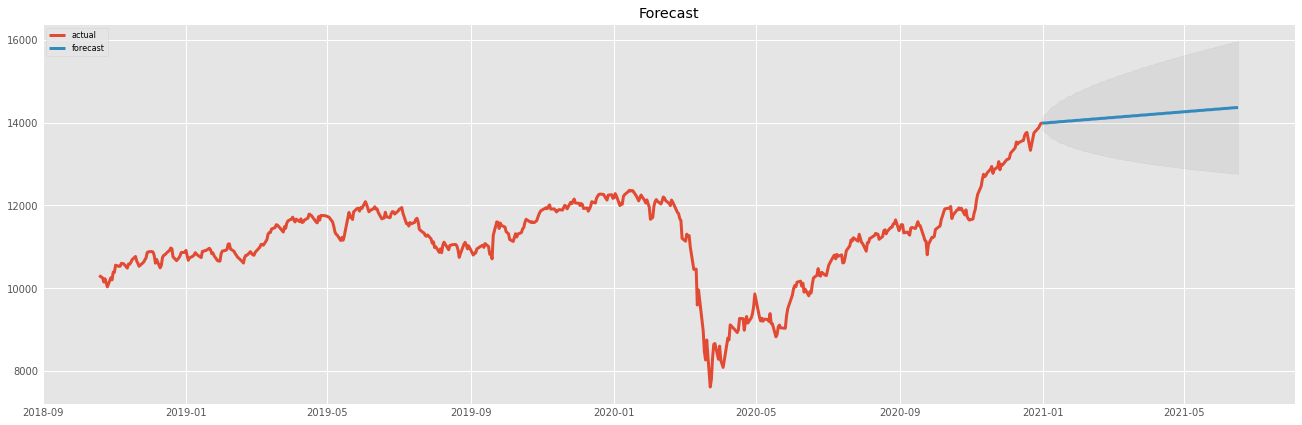

In [99]:
# Build Model
 
model = ARIMA(df['Nifty50'], order=(0, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

index_future_dates=pd.date_range(start='2020-12-31', periods=120, freq='B')
# Forecast
fc, se, conf = fitted.forecast(len(index_future_dates), alpha=0.1)  # 95% conf

# Make as pandas series

fc_series = pd.Series(fc, index=index_future_dates)
lower_series = pd.Series(conf[:, 0], index=index_future_dates)
upper_series = pd.Series(conf[:, 1], index=index_future_dates)
future_df = pd.DataFrame({"future_price" : fc_series , "lower" : lower_series , "upper" : upper_series} , index = index_future_dates)

# Plot
plt.figure(figsize=(20,7))

plt.plot(Test['Nifty50'], label='actual' ,lw = 3)
plt.plot(fc_series, label='forecast' , lw = 3)
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [100]:
print(fc_series.mean(),fc_series.std())


14174.78748291345 110.9838333597887


In [101]:
future_df.loc["2021-04-26"]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [107]:
future_df

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [108]:
future_df.describe()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

## With Exogenous

In [64]:
model_autox_pred = auto_arima(Train['Nifty50'],exogenous = Train[['reliance' , 'infosys' ,'hdfc' , 'hdfcbank']],
                 m = 5 ,max_p=5 , max_q= 5 , max_P= 5 , max_Q= 5 ,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=23879.341, Time=4.97 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=23875.849, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=23872.798, Time=0.77 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=23872.862, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=23878.153, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=23871.618, Time=0.28 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=23872.815, Time=0.62 sec
 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=23873.775, Time=3.23 sec
 ARIMA(2,1,0)(0,0,0)[5] intercept   : AIC=23873.616, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=23873.622, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=23871.657, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=23875.621, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[5]             : AIC=23873.467, Time=0.25 sec

Best model:  ARIMA(1,1,0)(0,0,0)[5] intercept
Total fit time: 13.288 seconds


In [65]:
model_autox_pred.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2183
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -11928.809
Date:                Sun, 25 Apr 2021   AIC                          23871.618
Time:                        19:44:19   BIC                          23911.434
Sample:                             0   HQIC                         23886.173
                               - 2183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.4161      1.399      1.727      0.084      -0.326       5.158
reliance       1.0571      0.012     87.748      0.000       1.033       1.081
infosys        0.1807      0.004     42.832      0.000       0.172       0.189
hdfc           0.2037      0.004     57.784      0.000       0.197       0.211
hdfcbank       0.2460      0.004     59.319      0.000       0.238       0.254
ar.L1          0.0536      0.022      2.425      0.015       0.010       0.097
sigma2      3282.6293     67.764     48.442      0.000    3149.814    3415.445
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            103870.01
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                             2.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:No supported index is available. Prediction results will be given with an integer index beginning at `start`.


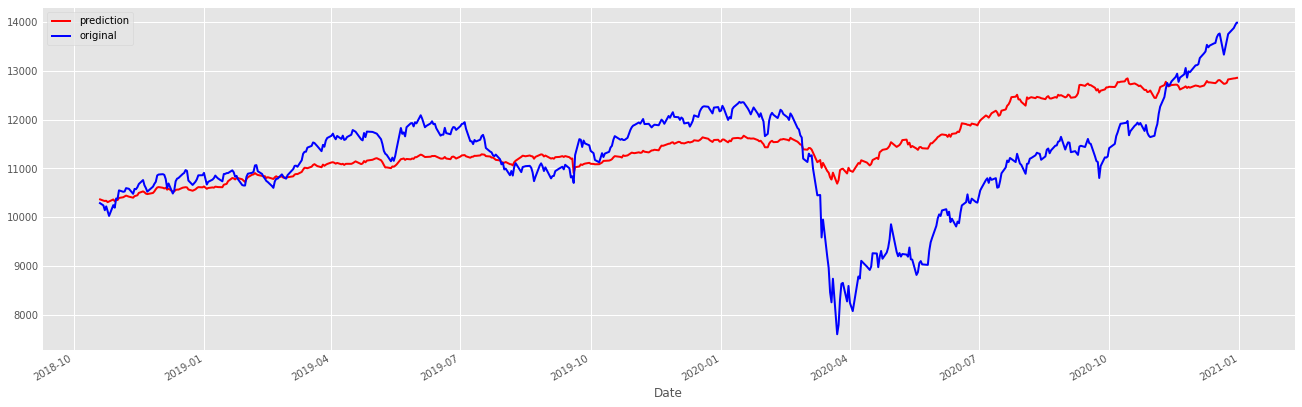

In [66]:

df_result_price_ex = pd.DataFrame(model_autox_pred.predict(n_periods = len(Test), 
                                                  exogenous = Test[['reliance' , 'infosys' ,'hdfc' , 'hdfcbank']]) ,
                        index =Test.index)
df_result_price_ex.plot(figsize=(20,5) ,color = "red" , lw = 2)
Test['Nifty50'].plot(figsize=(20,7),color = "blue" ,lw = 2)
plt.legend(['prediction' , 'original'])
plt.show()

In [67]:
print( "RMSE :" ,np.sqrt(mean_squared_error(Test['Nifty50'],df_result_price_ex)))
print("MAE :" , mean_absolute_error(Test['Nifty50'],df_result_price_ex))

RMSE : 972.1682831460294
MAE : 723.6572982922828


## One step ahead Prediction

In [68]:
model_sarimax = SARIMAX(df['Nifty50'],
                 order=(1,1,0) ,trend='c')
results_sarimax = model_sarimax.fit() 
print(results_sarimax)


c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning:A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.


In [69]:


one_step_forecast = results_sarimax.get_prediction(start=-30)
print(one_step_forecast)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean
# print(mean_forecast)

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

print(confidence_intervals)


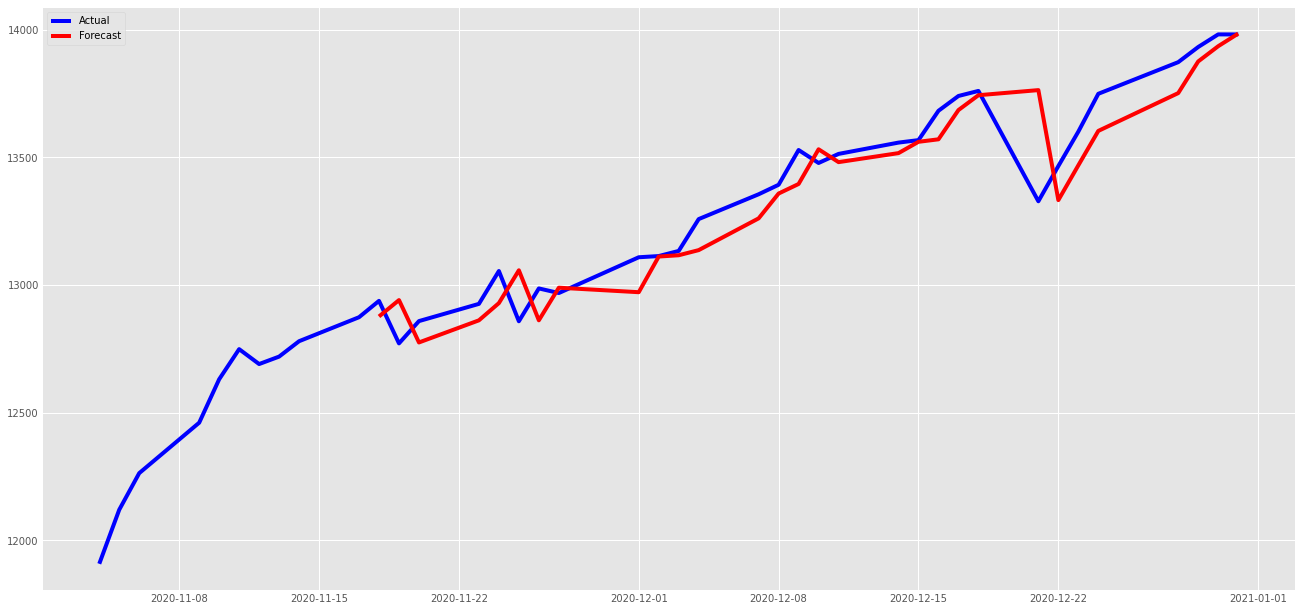

In [70]:
plt.plot(df.index[-40:] , df['Nifty50'][-40:].values , color = "blue" , label = "Actual")
plt.plot(df.index[-30:] , mean_forecast.values , color = "red" , label = "Forecast")
plt.legend()
plt.show()

In [71]:
print( "RMSE :" ,np.sqrt(mean_squared_error(df['Nifty50'][-30:],mean_forecast)))
print("MAE :" , mean_absolute_error(df['Nifty50'][-30:],mean_forecast))

RMSE : 124.38970416122339
MAE : 92.646138404535


## Dynamic Predictions

In [72]:
one_step_forecast = results_sarimax.get_prediction(start=-30 , dynamic = True)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean


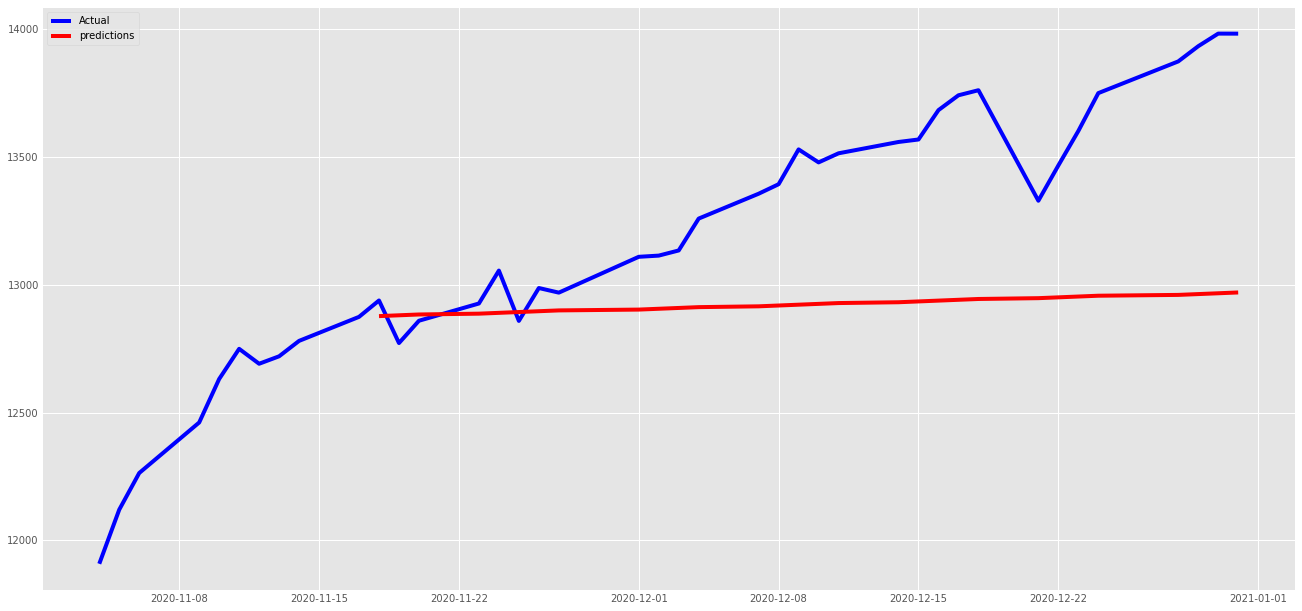

In [73]:
plt.plot(df.index[-40:] , df['Nifty50'][-40:].values , color = "blue" , label = "Actual")
plt.plot(df.index[-30:] , mean_forecast.values , color = "red" , label = "predictions")
plt.legend()
plt.show()

In [74]:
forecast = results_sarimax.get_forecast(steps = 200)
mean_forecast2 = forecast.predicted_mean

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:No supported index is available. Prediction results will be given with an integer index beginning at `start`.


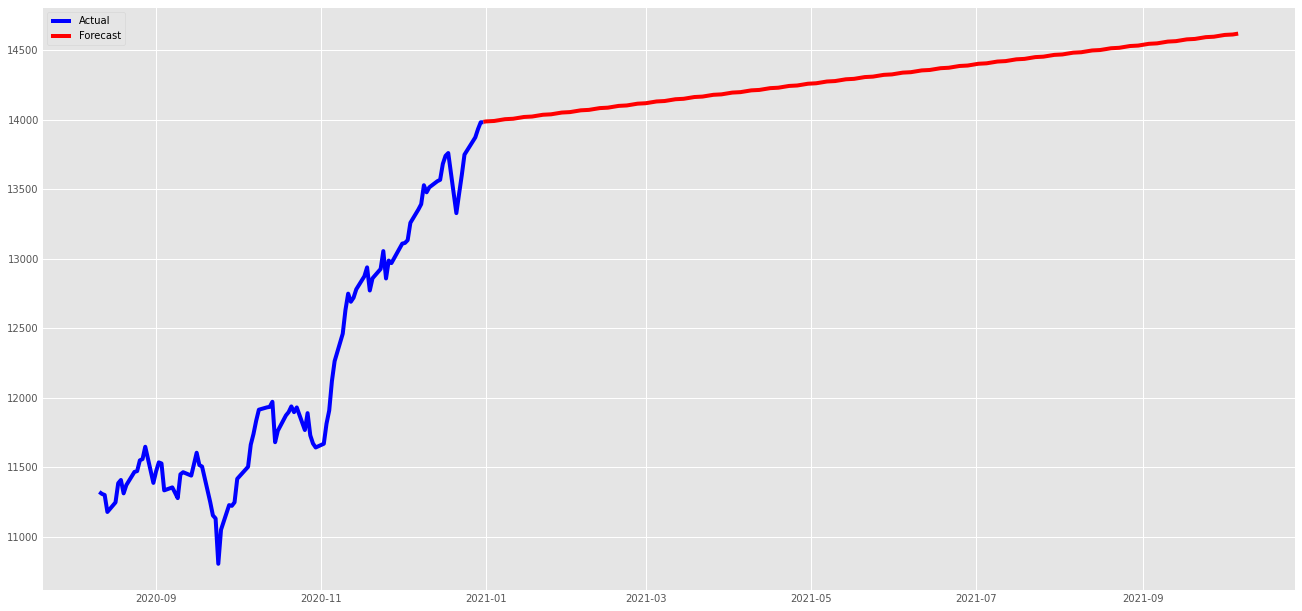

In [75]:
plt.plot(df.index[-100:] , df['Nifty50'][-100:].values , color = "blue" , label = "Actual")
plt.plot(pd.date_range(start='2020-12-31', periods=200, freq='B') ,mean_forecast2.values , color = "red" , label = "Forecast")
plt.legend()
plt.show()

In [77]:
df.index[-1:]

DatetimeIndex(['2020-12-31'], dtype='datetime64[ns]', name='Date', freq=None)

In [78]:
pd.date_range(start='2020-12-31', periods=30, freq='B')

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-04', '2021-01-05',
               '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-11',
               '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15',
               '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21',
               '2021-01-22', '2021-01-25', '2021-01-26', '2021-01-27',
               '2021-01-28', '2021-01-29', '2021-02-01', '2021-02-02',
               '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-08',
               '2021-02-09', '2021-02-10'],
              dtype='datetime64[ns]', freq='B')

## Check Volatility

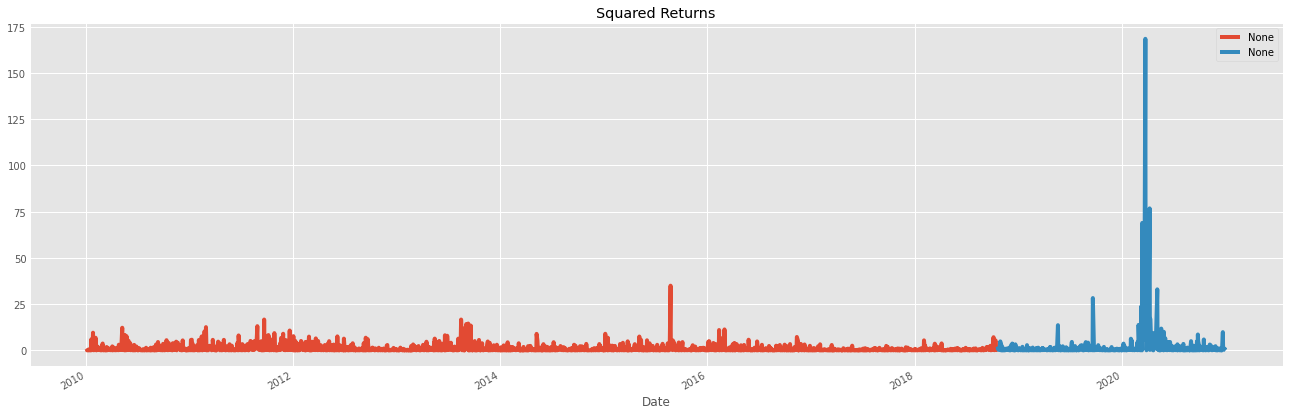

In [79]:
plt.figure(figsize= (20,7))
Train['nifty_sq_returns'].plot()
Test['nifty_sq_returns'].plot()
# Train['reliance_sq_returns'].plot()
# Train['infosys_sq_returns'].plot()
# Train['hdfc_sq_returns'].plot()
# Train['hdfcbank_sq_returns'].plot()
plt.legend()
plt.title("Squared Returns")
plt.show()

## Check for returns

In [80]:
model_auto_pred_ret = auto_arima(Train['nifty_returns'], m = 5 ,max_p=5 , max_q= 5 , max_P= 5 , max_Q= 5 ,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[5] intercept   : AIC=6101.957, Time=2.44 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=6101.391, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=6095.536, Time=0.21 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=6095.455, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=6102.429, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=6093.853, Time=0.12 sec
 ARIMA(0,0,1)(1,0,0)[5] intercept   : AIC=6095.447, Time=0.21 sec
 ARIMA(0,0,1)(1,0,1)[5] intercept   : AIC=6097.038, Time=0.96 sec
 ARIMA(1,0,1)(0,0,0)[5] intercept   : AIC=6095.852, Time=0.32 sec
 ARIMA(0,0,2)(0,0,0)[5] intercept   : AIC=6095.851, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=6093.939, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[5] intercept   : AIC=6096.636, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[5]             : AIC=6094.532, Time=0.05 sec

Best model:  ARIMA(0,0,1)(0,0,0)[5] intercept
Total fit time: 5.516 seconds


In [81]:
model_auto_pred_ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2183
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -3043.926
Date:                Sun, 25 Apr 2021   AIC                           6093.853
Time:                        19:44:26   BIC                           6110.918
Sample:                             0   HQIC                          6100.091
                               - 2183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0365      0.022      1.628      0.104      -0.007       0.080
ma.L1          0.0663      0.019      3.410      0.001       0.028       0.104
sigma2         0.9521      0.021     44.668      0.000       0.910       0.994
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               261.39
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

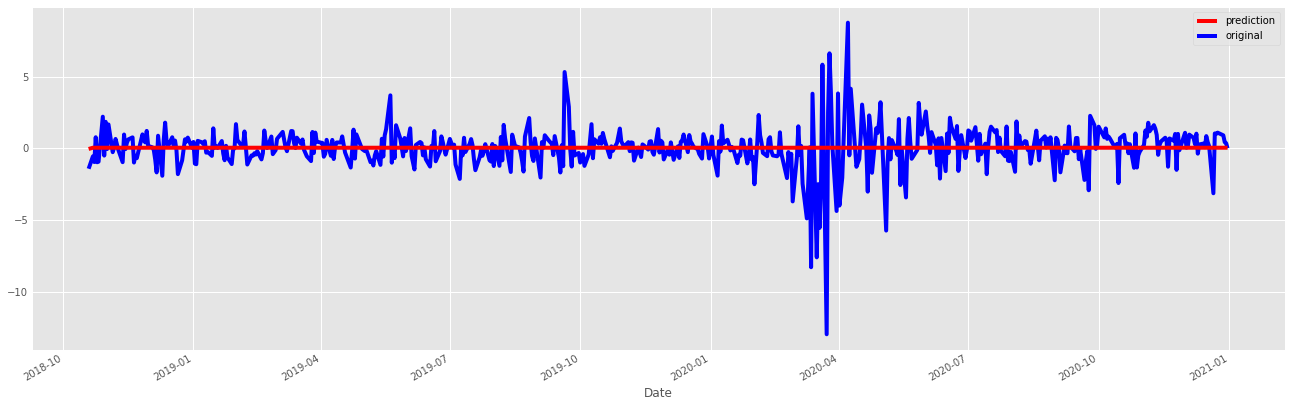

In [82]:

df_result_ret = pd.DataFrame(model_auto_pred_ret.predict(n_periods = len(Test)), index =Test.index)
                             
df_result_ret.plot(figsize=(20,7) ,color = "red" , zorder = 2)
Test['nifty_returns'].plot(figsize=(20,7),color = "blue" ,  zorder = 1)
plt.legend(['prediction' , 'original'])
plt.show()

In [83]:
print( "RMSE :" ,np.sqrt(mean_squared_error(Test['nifty_returns'],df_result_ret)))
print("MAE :" , mean_absolute_error(Test['nifty_returns'],df_result_ret))

RMSE : 1.4814145095047278
MAE : 0.9143260347586856


## With Exog

In [84]:
model_autox_pred_ret = auto_arima(Train['nifty_returns'],
                                  exogenous = Train[['reliance_returns' , 'infosys_returns' ,'hdfc_returns' , 'hdfcbank_returns']],
                 m = 5 ,max_p=5 , max_q= 5 , max_P= 5 , max_Q= 5 ,trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[5] intercept   : AIC=4485.327, Time=4.67 sec
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=4483.293, Time=0.16 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=4486.017, Time=0.56 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=4486.044, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=4483.848, Time=0.41 sec
 ARIMA(0,0,0)(1,0,0)[5] intercept   : AIC=4484.962, Time=0.49 sec
 ARIMA(0,0,0)(0,0,1)[5] intercept   : AIC=4484.975, Time=0.53 sec
 ARIMA(0,0,0)(1,0,1)[5] intercept   : AIC=4486.145, Time=1.57 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=4484.327, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=4484.342, Time=0.31 sec
 ARIMA(1,0,1)(0,0,0)[5] intercept   : AIC=4486.251, Time=1.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[5] intercept
Total fit time: 10.948 seconds


In [85]:
model_autox_pred_ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2183
Model:                        SARIMAX   Log Likelihood               -2235.646
Date:                Sun, 25 Apr 2021   AIC                           4483.293
Time:                        19:44:37   BIC                           4517.424
Sample:                             0   HQIC                          4495.770
                               - 2183                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.0231      0.018      1.299      0.194      -0.012       0.058
reliance_returns     0.2078      0.002     86.923      0.000       0.203       0.212
infosys_returns      0.0785      0.002     48.461      0.000       0.075       0.082
hdfc_returns         0.1184      0.002     77.260      0.000       0.115       0.121
hdfcbank_returns     0.1172      0.001     82.422      0.000       0.114       0.120
sigma2               0.4540      0.010     45.846      0.000       0.435       0.473
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):            430940.33
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             4.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        71.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning:No supported index is available. Prediction results will be given with an integer index beginning at `start`.


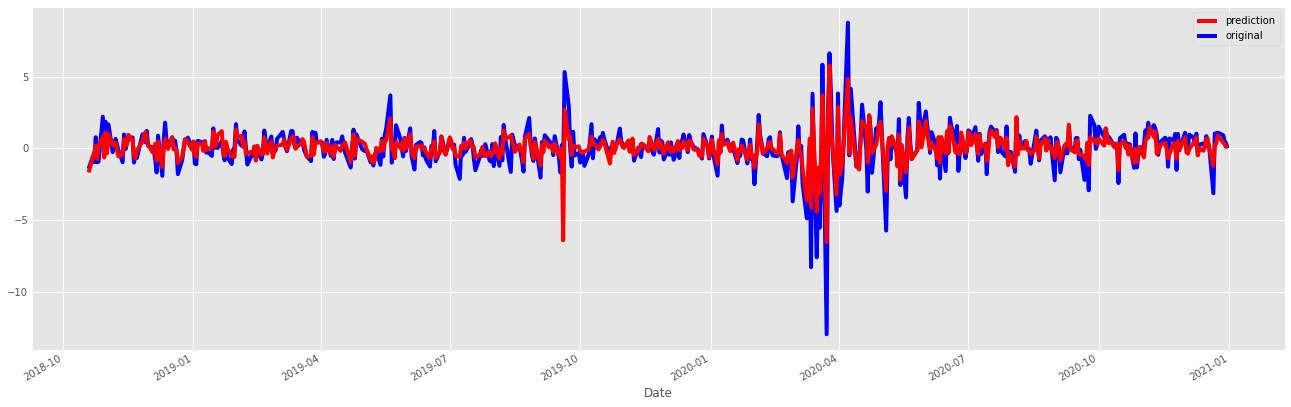

In [86]:

df_result_ret_exog = pd.DataFrame(model_autox_pred_ret.predict(n_periods = len(Test), 
                                                  exogenous = Test[['reliance_returns' , 'infosys_returns' ,'hdfc_returns' , 'hdfcbank_returns']]) ,
                        index =Test.index)
df_result_ret_exog.plot(figsize=(20,7) ,color = "red" , zorder = 2)
Test['nifty_returns'].plot(figsize=(20,7),color = "blue" ,  zorder = 1)
plt.legend(['prediction' , 'original'])
plt.show()

In [87]:
print( "RMSE :" ,np.sqrt(mean_squared_error(Test['nifty_returns'],df_result_ret_exog)))
print("MAE :" , mean_absolute_error(Test['nifty_returns'],df_result_ret_exog))

RMSE : 0.7761432687533112
MAE : 0.4982236733478867


## Seasonal Decompose

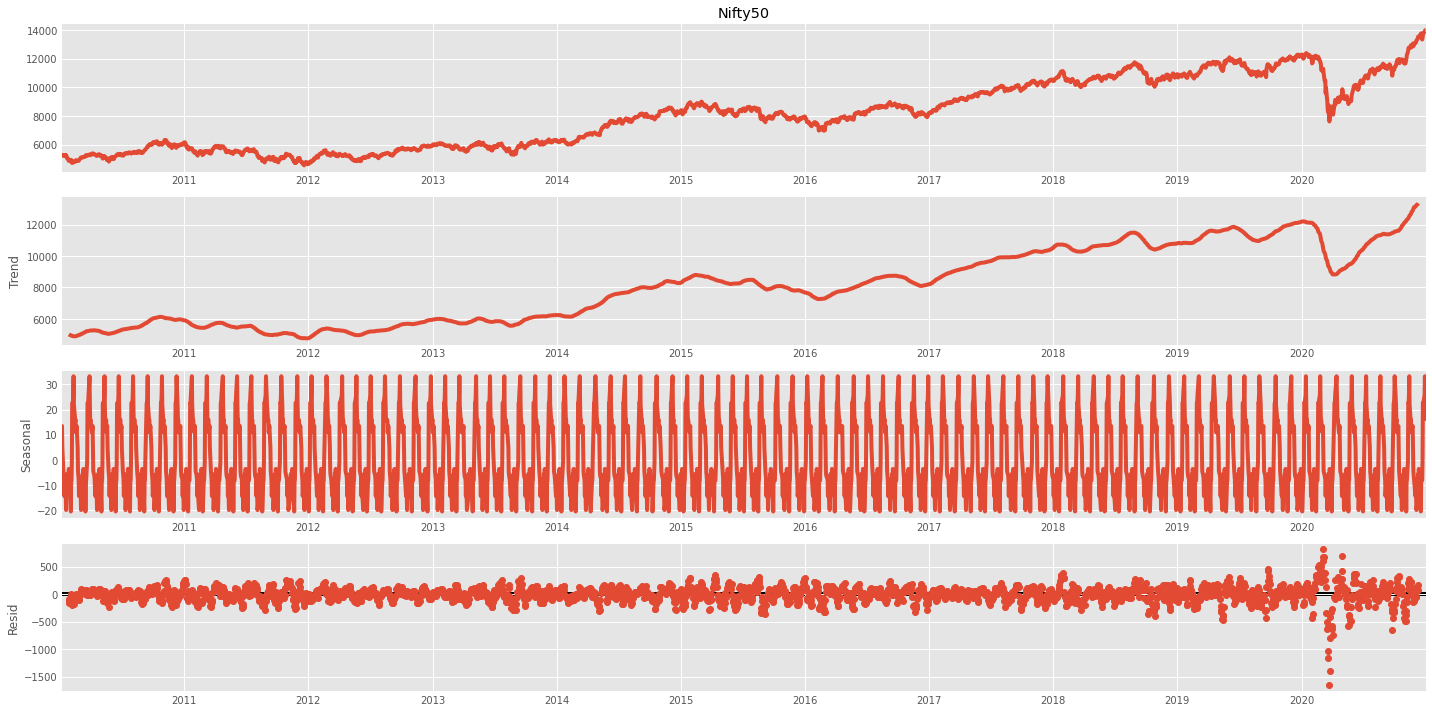

In [88]:

s_dec_add = seasonal_decompose(df.Nifty50, model='additive', period=30)
s_dec_add.plot()
plt.show()

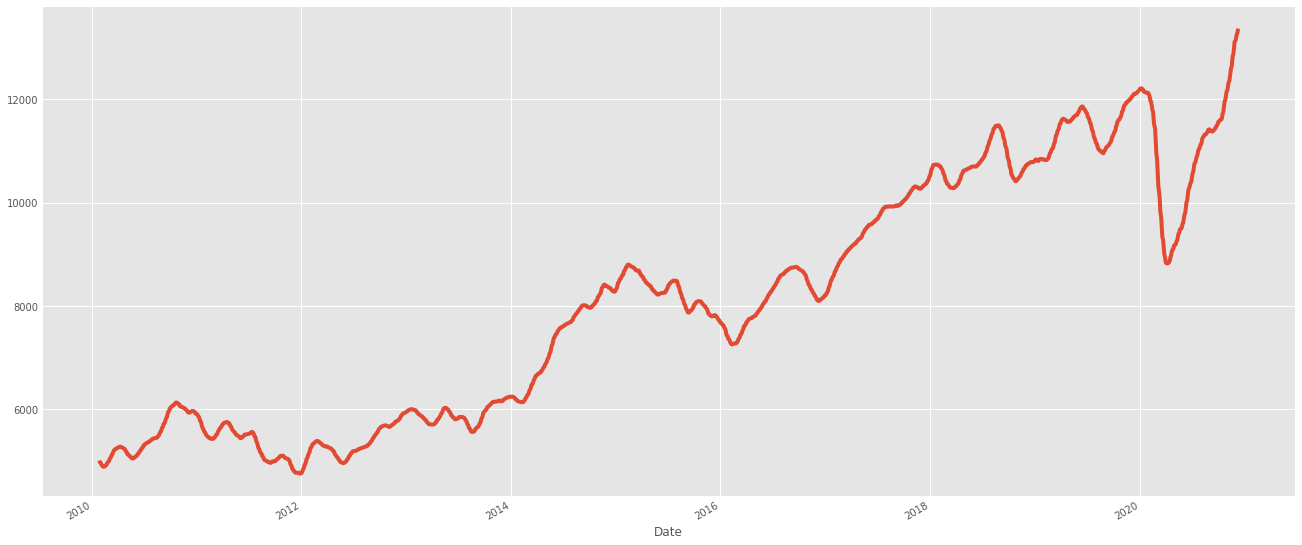

In [89]:
plt.figure(figsize=(20,10))
s_dec_add.trend.plot()
plt.show()

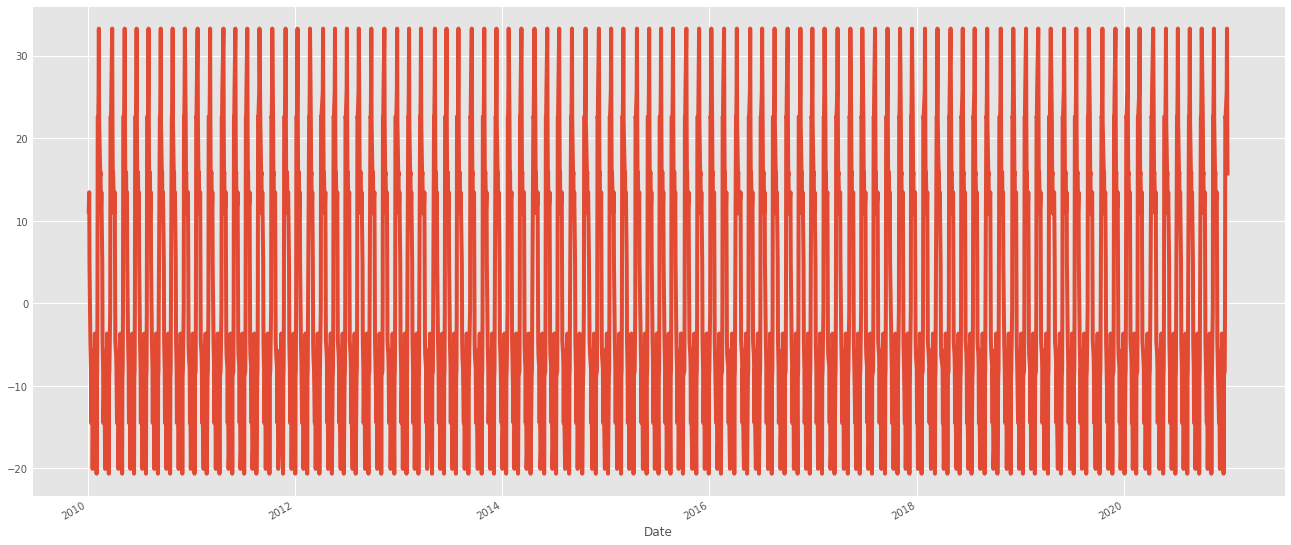

In [90]:
plt.figure(figsize=(20,10))
s_dec_add.seasonal.plot()
plt.show()

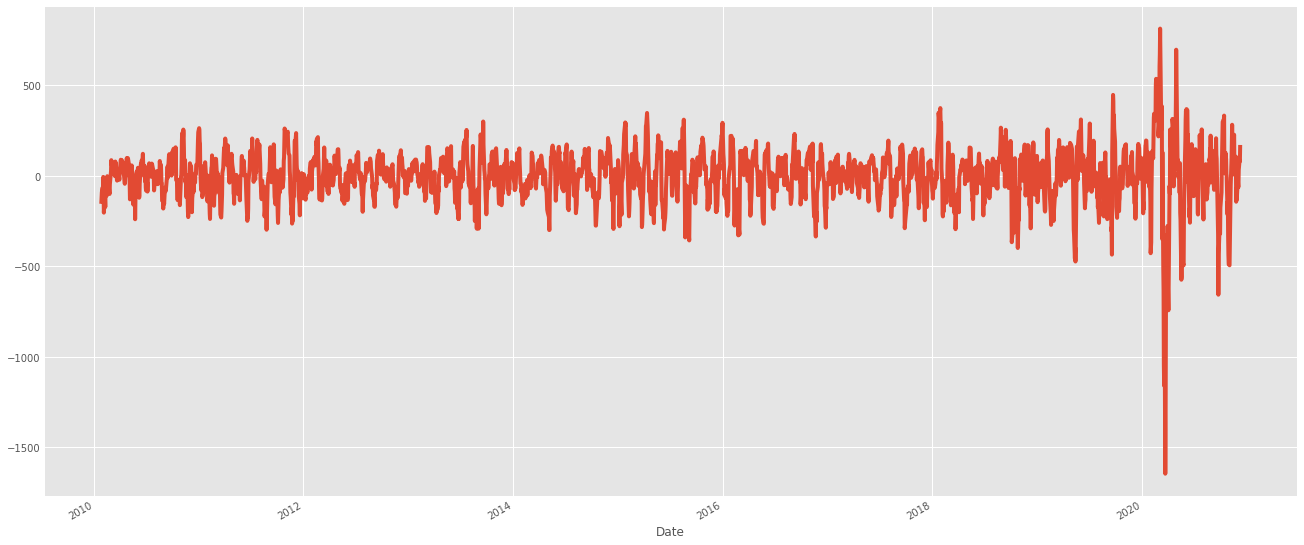

In [91]:
plt.figure(figsize=(20,10))
s_dec_add.resid.plot()
plt.show()

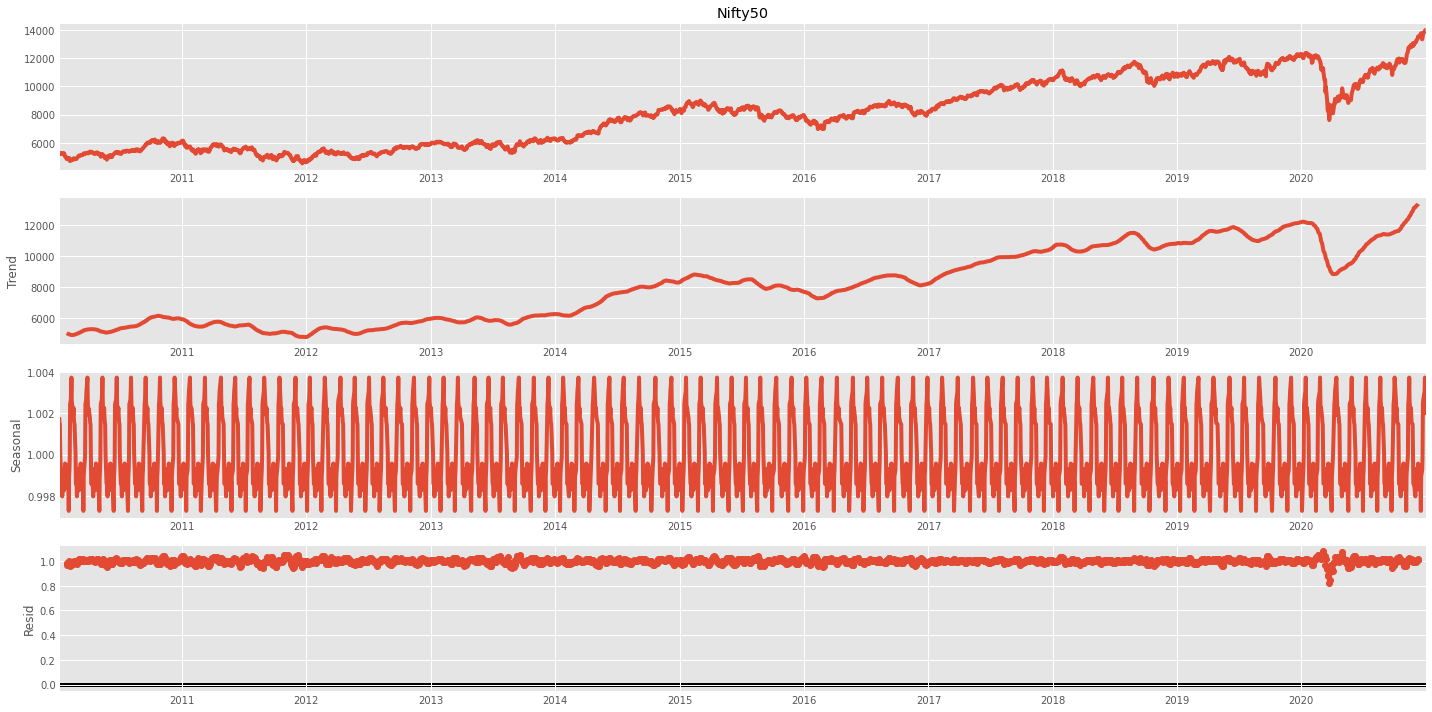

In [92]:
s_dec_mul = seasonal_decompose(df.Nifty50 , model="multiplicative" , period= 30)
s_dec_mul.plot()
plt.show()

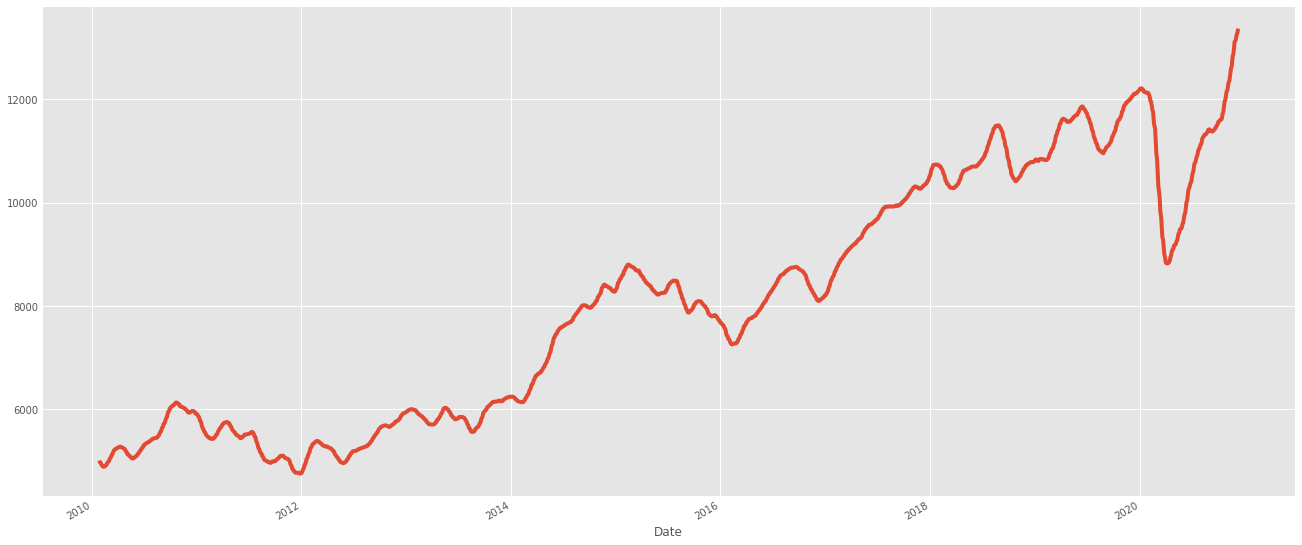

In [93]:
plt.figure(figsize=(20,10))
s_dec_mul.trend.plot()
plt.show()

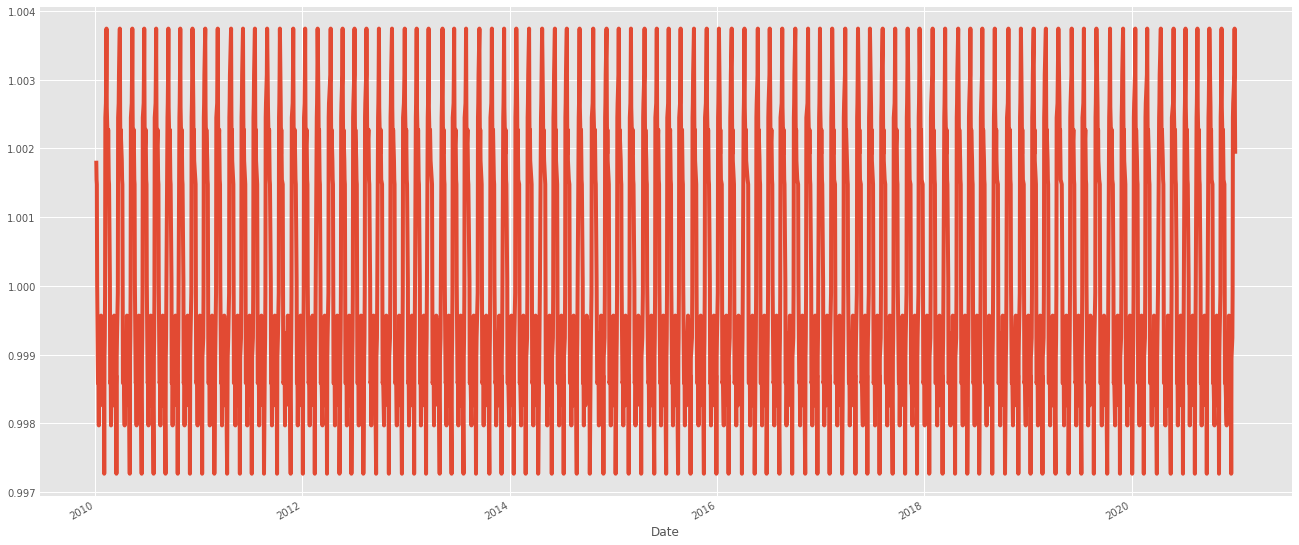

In [94]:
plt.figure(figsize=(20,10))
s_dec_mul.seasonal.plot()
plt.show()

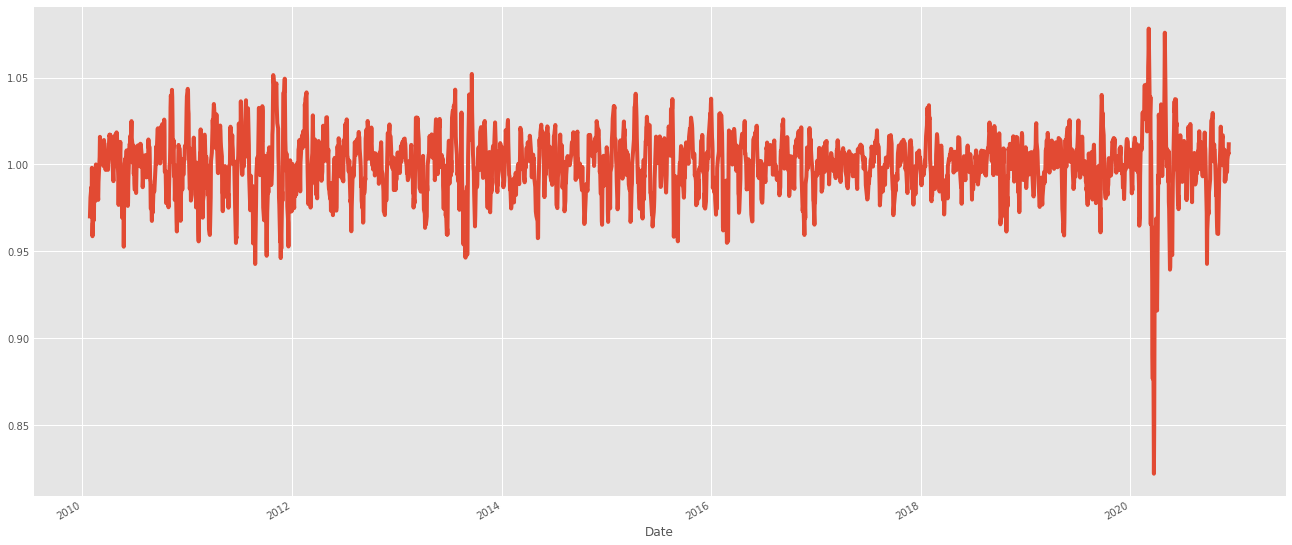

In [95]:
plt.figure(figsize=(20,10))
s_dec_mul.resid.plot()
plt.show()

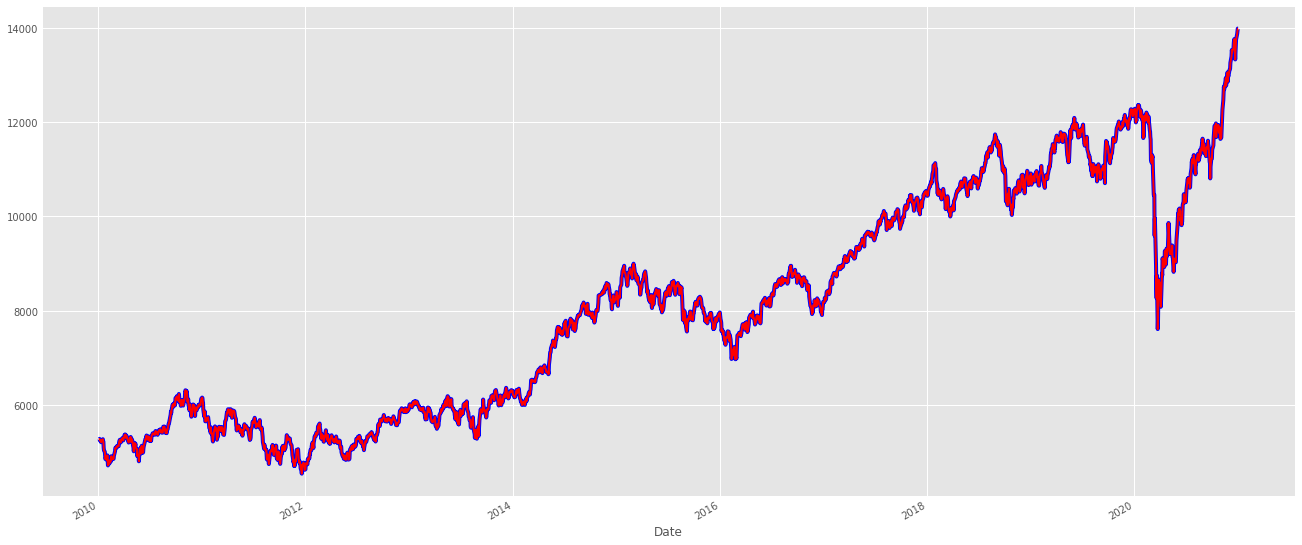

In [113]:
deseason = df['Nifty50'] - s_dec_mul.seasonal
plt.figure(figsize=(20,10))
df['Nifty50'].plot(color = "blue")
deseason.plot(color = "red" , lw = 2)
plt.show()

In [96]:
%matplotlib qt
from matplotlib import animation

x = df.index[-500:]
y = df['Nifty50'][-500:]

# animation line plot example

fig, ax = plt.subplots(1, 1, figsize = (20, 7))

def animate(i):
    ax.cla() # clear the previous image
    ax.plot(x[:i], y[:i]) # plot the line

anim = animation.FuncAnimation(fig, animate, frames = len(x)+1, interval = 0.01, repeat=False)
# anim.save('plot.gif')
# plt.show()
